<a href="https://colab.research.google.com/github/Gamma1024/ML_in_Finance/blob/main/ClassificationProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning in Finance: Final Project of Group 2


Note: Some code blocks may take several hours to execute.

## Exploratory Data Analysis

In [2]:
############## Importing Necessary Packages ##############
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold , cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from numpy import isnan
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import KernelPCA
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset, SubsetRandomSampler
from torch.autograd import Variable


In [3]:
!git clone https://github.com/Gamma1024/ML_in_Finance.git

Cloning into 'ML_in_Finance'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 34 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [4]:
############## Loading The Data ##############
## Loading findata
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
findata_2014 = pd.read_csv("ML_in_Finance/Data/2014_Financial_Data.csv", index_col = 0)
findata_2015 = pd.read_csv("ML_in_Finance/Data/2015_Financial_Data.csv", index_col = 0)
findata_2016 = pd.read_csv("ML_in_Finance/Data/2016_Financial_Data.csv", index_col = 0)
findata_2017 = pd.read_csv("ML_in_Finance/Data/2017_Financial_Data.csv", index_col = 0)
findata_2018 = pd.read_csv("ML_in_Finance/Data/2018_Financial_Data.csv", index_col = 0)
print(findata_2014.shape)
print(findata_2015.shape)
print(findata_2016.shape)
print(findata_2017.shape)
print(findata_2018.shape)
findata_2014._get_numeric_data().columns.shape
is_numeric_dtype(findata_2014["Sector"]) # categorical variable we need to convert later on

(3808, 224)
(4120, 224)
(4797, 224)
(4960, 224)
(4392, 224)


False

The original task on [kaggle](https://www.kaggle.com/cnic92/200-financial-indicators-of-us-stocks-20142018) was to classify the data into buy-worthy and non-buy-worthy stocks. For this task the last column consists of the dummy variable "Class" which indicates whether one should buy or not buy a particular stock in the beginning of the corresponding year. Hence, we need to transform the column "Class" so that it can take the values 0 for **Sell**, 1 for **Hold** and 2 for **Buy**. For this we calculate the excess return over the benchmark i.e. the S&P 500 and classify the stocks based on their excess return into the classes 2/Buy if excess_return > 2.5%, 1/Hold if excess_return $\in$ [-2.5%, 2.5%] and 0/Sell if excess_return < -2.5%. Later on we want to concatenate the dataframes and therefore we change the name of the columns "201x PRICE VAR [%]" to "PRICE VAR [%]" so that the name of the variable is the same for all years. For simplicity, we also created our own variables in the loop below. The S&P500 data can be found [here](https://www.macrotrends.net/2526/sp-500-historical-annual-returns) and the inflation forecasts [here](https://knoema.de/kyaewad/us-inflation-forecast-2022-2023-and-long-term-to-2030-data-and-charts).

In [5]:
############## Change Variable "Class" ##############
## Yearly Means of S&P 500
sp500_means = pd.Series([11.39, -0.73, 9.54, 19.42, -6.24], 
                        index = ["2015", "2016", "2017", "2018", "2019"])
inflation_forecast = pd.Series([2015, 2016, 2017, 2018, 2019], 
                               index = ["2015", "2016", "2017", "2018", "2019"])
print(sp500_means)

# [0.12, 1.27, 2.14, 2.43, 1.81]
looplist = [[findata_2014, "2015 PRICE VAR [%]", "2015"], [findata_2015, "2016 PRICE VAR [%]", "2016"], [findata_2016, "2017 PRICE VAR [%]", "2017"],
            [findata_2017, "2018 PRICE VAR [%]", "2018"], [findata_2018, "2019 PRICE VAR [%]", "2019"]]
for data, price_var, year in looplist:
   ## Subtracting S&P 500 means to get excess return
   # e.g. findata_2014["excess_return"] = np.subtract(findata_2014["2015 PRICE VAR [%]"], sp500_means[0])
   data["excess_return"] = np.subtract(data[price_var], sp500_means[year])
   ## rename the columns 201x PRICE VAR [%] to PRICE VAR [%] to concatenate
   data.columns = ["PRICE VAR [%]" if x == price_var else x for x in data.columns]
   ## Reassigning Class
   # class 2 if excess_return>2.5, 0 if excess_return < -2.5, else class 1
   data["Class"] = data["excess_return"].apply(lambda x: 2 if x > 2.5 else (0 if x < -2.5 else 1))
   print(data["PRICE VAR [%]"].isna().sum())
   #######################
   # Feature Engineering #
   #######################
   ## Calculate Operating Margin
   data["cashflow_margin"] = data["Operating Cash Flow"].divide(data["Revenue"])
   # instead of raising ZeroDivisionError, pandas saves zero division by infinity
   data["cashflow_margin"] = data["cashflow_margin"].replace([np.inf, -np.inf], np.nan)
   ## Calculate RONA
   data["operating_liabilities"] = data["Total liabilities"]-data["Total debt"]
   data["NIC"] = data["Total assets"]-data["Cash and cash equivalents"]
   data["RONA"] = data["EBIT"]/data["NIC"]
   data["RONA"] = data["RONA"].replace([np.inf, -np.inf], np.nan)

   ## Expected Inflation
   data["expected_inflation"] = inflation_forecast[year]



# no NA's in the column "PRICE VAR [%]"

print(findata_2014.iloc[::,222:226].head()) # column 223 is "Class", 224 is "excess_return"


2015    11.39
2016    -0.73
2017     9.54
2018    19.42
2019    -6.24
dtype: float64
0
0
0
0
0
      PRICE VAR [%]  Class  excess_return  cashflow_margin
PG        -9.323276      0     -20.713276         0.187605
VIPS     -25.512193      0     -36.902193         0.141062
KR        33.118297      2      21.728297         0.036320
RAD        2.752291      0      -8.637709         0.027503
GIS       12.897715      1       1.507715         0.141879


In [6]:
# %%timeit
# for data in [findata_2014, findata_2015, findata_2016, findata_2017, findata_2018]:
#    data["Class"] = data["excess_return"].apply(lambda x: 2 if x > 2.5 else (0 if x < -2.5 else 1))

In [7]:
############## Concatenating the Data ##############
## Concatenate the Data
frames = [findata_2014, findata_2015, findata_2016, findata_2017,
          findata_2018]
findata = pd.concat(frames)

## Let's investigat our newly created dataframe a bit:
print(findata.shape)
print(findata.head(3))
print(findata.info())
print(findata[["excess_return", "PRICE VAR [%]"]].describe())
print("-------------------------------------------------------------------------")
# print contingency table of Class and Sector 
print(pd.crosstab(index = findata["Sector"], columns = findata["Class"], margins = True)) 
print("-------------------------------------------------------------------------")
# print contingency table of proportions of Class and Sector 
print(pd.crosstab(index = findata["Sector"], columns = findata["Class"], normalize = "index"))

(22077, 230)
           Revenue  Revenue Growth  Cost of Revenue  Gross Profit  \
PG    7.440100e+10         -0.0713     3.903000e+10  3.537100e+10   
VIPS  3.734148e+09          1.1737     2.805625e+09  9.285226e+08   
KR    9.837500e+10          0.0182     7.813800e+10  2.023700e+10   

      R&D Expenses  SG&A Expense  Operating Expenses  Operating Income  \
PG    0.000000e+00  2.146100e+10        2.146100e+10      1.391000e+10   
VIPS  1.083303e+08  3.441414e+08        7.939267e+08      1.345959e+08   
KR    0.000000e+00  1.519600e+10        1.751200e+10      2.725000e+09   

      Interest Expense  Earnings before Tax  ...  SG&A Expenses Growth  \
PG        7.090000e+08         1.449400e+10  ...               -0.1746   
VIPS      1.214869e+07         1.753823e+08  ...                1.7313   
KR        4.430000e+08         2.270000e+09  ...                0.0234   

                  Sector  PRICE VAR [%]  Class  excess_return  \
PG    Consumer Defensive      -9.323276      0     

We see that the mean is a lot bigger than the median for the excess_return and the PRICE VAR [%] indicating a right skewed distribution. Further investigations below show that the reason for this is that there are a few companies whose returns were (sometimes much) greater than 1000% percent and thus levereging the mean. We can also see that the class proportions vary between the different sectors. We decided not to drop the observations with such extreme returns since for our task only the class of importance and not the exact return value.

-5.281841982079795
GNL     2.418601e+06
BW      6.955667e+05
NK      1.732000e+05
PUB     1.443588e+05
RUN     7.836667e+04
BKI     6.602000e+04
SUM     4.023329e+04
JP      2.520000e+04
JAX     2.416667e+04
OPNT    1.960000e+04
AMRH    1.310000e+04
PEN     9.864815e+03
PJT     6.799999e+03
FSB     5.843182e+03
YRIV    2.933333e+03
LBCC    2.292857e+03
CC      2.248621e+03
GBT     1.993912e+03
SSNT    1.041667e+03
BSM     1.000607e+03
Name: PRICE VAR [%], dtype: float64
RHE    -100.397220
ARA     -98.333333
FTAI    -98.289550
AAMC    -94.755181
RGSE    -94.272727
GLBS    -93.913044
EIGR    -92.711948
AEZS    -92.533333
TELL    -92.527174
SCON    -92.500000
COE     -92.299086
APEN    -91.929825
RSLS    -91.268447
CPST    -90.540541
SBLK    -90.032680
NXTD    -89.915966
GOL     -89.560440
USEG    -89.333333
YUMA    -89.204545
NSPR    -89.000000
Name: PRICE VAR [%], dtype: float64


(0.0, 0.9)

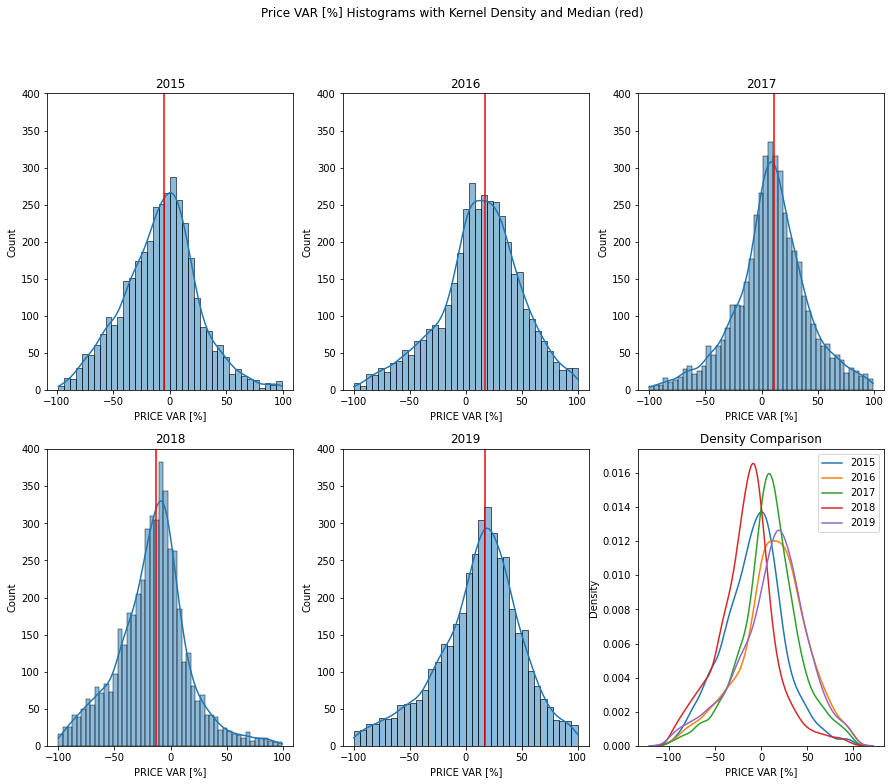

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

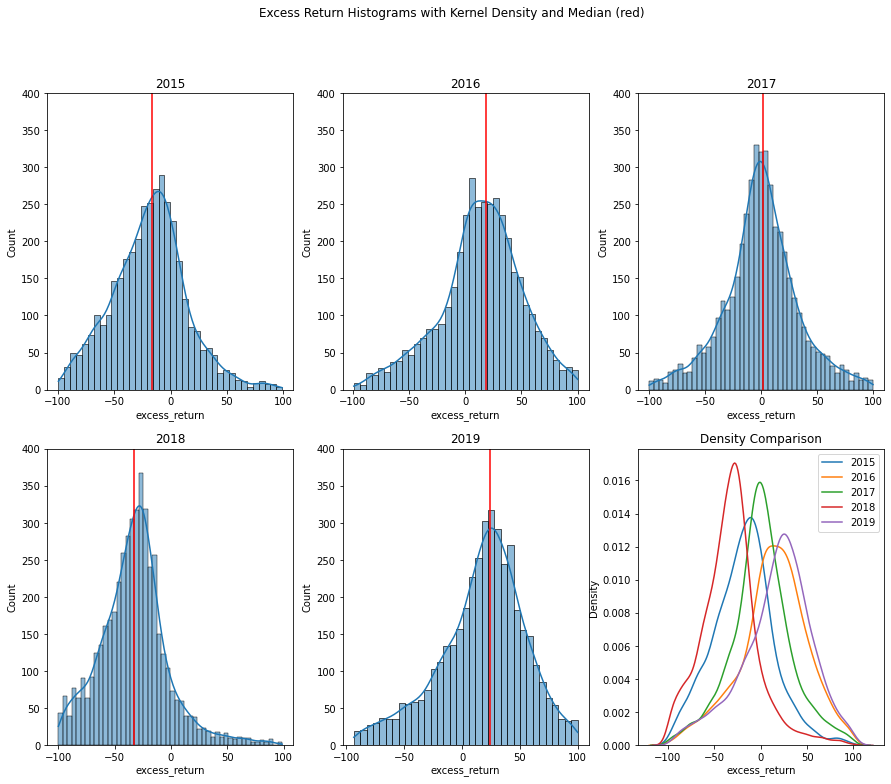

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

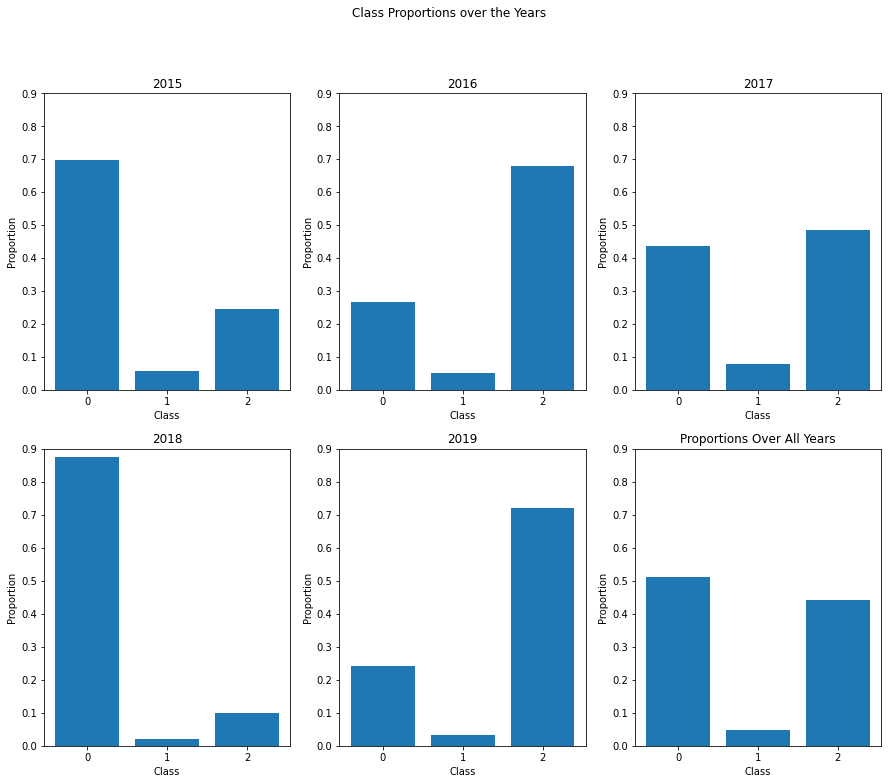

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [8]:
############## Further Investigations ##############
print(np.median(findata_2014.iloc[:, 222]))
print(findata_2014.iloc[:, 222].nlargest(n = 20)) 
print(findata_2014.iloc[:, 222].nsmallest(n = 20))
# very extreme returns, thus need to adjust xrange in plots to not get range from min to max observation
plotloop = [[findata_2014, "2015", 0], [findata_2015, "2016", 1], [findata_2016, "2017", 2], [findata_2017, "2018", 3], [findata_2018, "2019", 4]]

## Plot Histogram of Price VAR [%] for each year
fig, ax = plt.subplots(nrows = 2 , ncols = 3 , figsize=(15, 12)) # create plot matrix with 2 rows and 3 columns
fig.suptitle("Price VAR [%] Histograms with Kernel Density and Median (red)")
ax = ax.ravel() # flatten the axis array
for data, year, k in plotloop:
  data_hist = data.iloc[:, 222][data.iloc[:, 222].between(-100, 100)]
  # only consider returns between -100% and 100% so that histogram is not influenced by very extreme values
  ax[k].set_title(year)
  plt.figure()
  sns.histplot(data_hist, kde = True, ax = ax[k])
  ax[k].set_ylim(0, 400)
  ax[k].axvline(x=np.median(data.iloc[:, 222]), color="red") # vertical line with median of the column PRICE VAR [%] of year 201x
  # Plot density of all years together to compare them
  sns.kdeplot(data_hist, label = year, ax = ax[5])
ax[5].legend()
ax[5].set_title("Density Comparison")

## Plot Histogram of excess_return for each year
fig, ax = plt.subplots(nrows = 2 , ncols = 3 , figsize=(15, 12)) 
fig.suptitle("Excess Return Histograms with Kernel Density and Median (red)")
ax = ax.ravel()
for data, year, k in plotloop:
  data_hist = data.iloc[:, 224][data.iloc[:, 224].between(-100, 100)]
  # only consider returns between -100% and 100% so that histogram is not influenced by very extreme values
  ax[k].set_title(year)
  plt.figure()
  sns.histplot(data_hist, kde = True, ax = ax[k])
  ax[k].set_ylim(0, 400)
  ax[k].axvline(x=np.median(data.iloc[:, 224]), color="red") # vertical line with median of the column excess_return of year 201x
  # Plot density of all years together to compare them
  sns.kdeplot(data_hist, label = year, ax = ax[5])
ax[5].legend()
ax[5].set_title("Density Comparison")

## Plot Barplot of proportion of Class for each year
fig, ax = plt.subplots(nrows = 2 , ncols = 3 , figsize=(15, 12)) 
fig.suptitle("Class Proportions over the Years")
ax = ax.ravel()
y_pos = np.arange(3)
for data, year, k in plotloop:
  ax[k].set_title(year)
  plt.figure()
  ax[k].set_xlabel("Class") # set common x label
  ax[k].set_ylabel("Proportion") # set common y label
  height = [sum(data["Class"] ==0)/data.shape[0], sum(data["Class"] ==1)/data.shape[0], sum(data["Class"] ==2)/data.shape[0]]
  ax[k].bar(y_pos, height)
  ax[k].set_xticks([0, 1, 2]) 
  ax[k].set_xticklabels([0, 1, 2])
  ax[k].set_ylim(0, 0.9)
sell_prop  = sum(findata["Class"] == 0)/findata.shape[0]
hold_prop = sum(findata["Class"] == 1)/findata.shape[0]
buy_prop = sum(findata["Class"] ==2)/findata.shape[0]

height = [sell_prop, hold_prop, buy_prop]
ax[5].bar(y_pos, height)
ax[5].set_xticks([0, 1, 2]) 
ax[5].set_xticklabels([0, 1, 2])
ax[5].set_xlabel("Class")
ax[5].set_ylabel("Proportion")
ax[5].set_title("Proportions Over All Years")
ax[5].set_ylim(0, 0.9)

Next, we need to check whether there are some identical columns and/ or rows. If so, drop all of these identical rows/ columns but one.

In [9]:
############## Remove Identical Columns ##############
na_sum = findata.isna().sum()
na_sum_series = na_sum.squeeze() # convert data frame to pandas series
print(na_sum_series.sort_values(ascending = False).head(10)) # sort values in descending order

identical_columns = [] # create empty list to store identical columns
for i in range(findata.shape[1]):
  for j in range(i+1, findata.shape[1]):
    if findata.iloc[:, i].equals(findata.iloc[:, j])==1: # pairwise compare columns whether they are identical or not
      identical_columns.append([findata.columns[i], findata.columns[j]]) # append identical columns to list identical_columns
for column1, column2 in identical_columns:
  findata.drop(column1, axis = 1, inplace = True) # drop one of the two columns that are identical
print(identical_columns)
findata.shape # 11 columns identical since we went from 231 to 220 columns

cashConversionCycle                           22058
operatingCycle                                22058
shortTermCoverageRatios                       10744
10Y Shareholders Equity Growth (per Share)     9680
10Y Net Income Growth (per Share)              9532
10Y Revenue Growth (per Share)                 9532
10Y Operating CF Growth (per Share)            9478
10Y Dividend per Share Growth (per Share)      9177
dividendPayoutRatio                            9079
priceEarningsToGrowthRatio                     9079
dtype: int64
[['ebitperRevenue', 'eBITperRevenue'], ['ebtperEBIT', 'eBTperEBIT'], ['niperEBT', 'nIperEBT'], ['returnOnAssets', 'Return on Tangible Assets'], ['returnOnCapitalEmployed', 'ROIC'], ['payablesTurnover', 'Payables Turnover'], ['inventoryTurnover', 'Inventory Turnover'], ['debtRatio', 'Debt to Assets'], ['debtEquityRatio', 'Debt to Equity'], ['cashFlowToDebtRatio', 'cashFlowCoverageRatios']]


(22077, 220)

In [10]:
############## Remove Identical Rows ##############
sum(findata.duplicated(subset = None)) # check how many rows are identical
# There are no identical rows

0

While analyzing the data, we realized that NA's and the value 0 are often used interchangeably. To make the data uniform, we decided to convert the 0's into NA's. For 3 columns, however, the 0's could actually represent the true values. These columns are "Tax Liabilities", "Preferred Dividends" and "Goodwill and intangible assets". However, because a high proportion of these columns have the value 0, these features are not informative either way and we decided to drop them. As a consequence, we decided to convert the 0's in all columns to NA's.

PG             NaN
VIPS           NaN
KR             NaN
RAD     33998000.0
GIS            NaN
Name: Preferred Dividends, dtype: float64 PG      0
VIPS    0
KR      2
RAD     0
GIS     1
Name: Class, dtype: int64


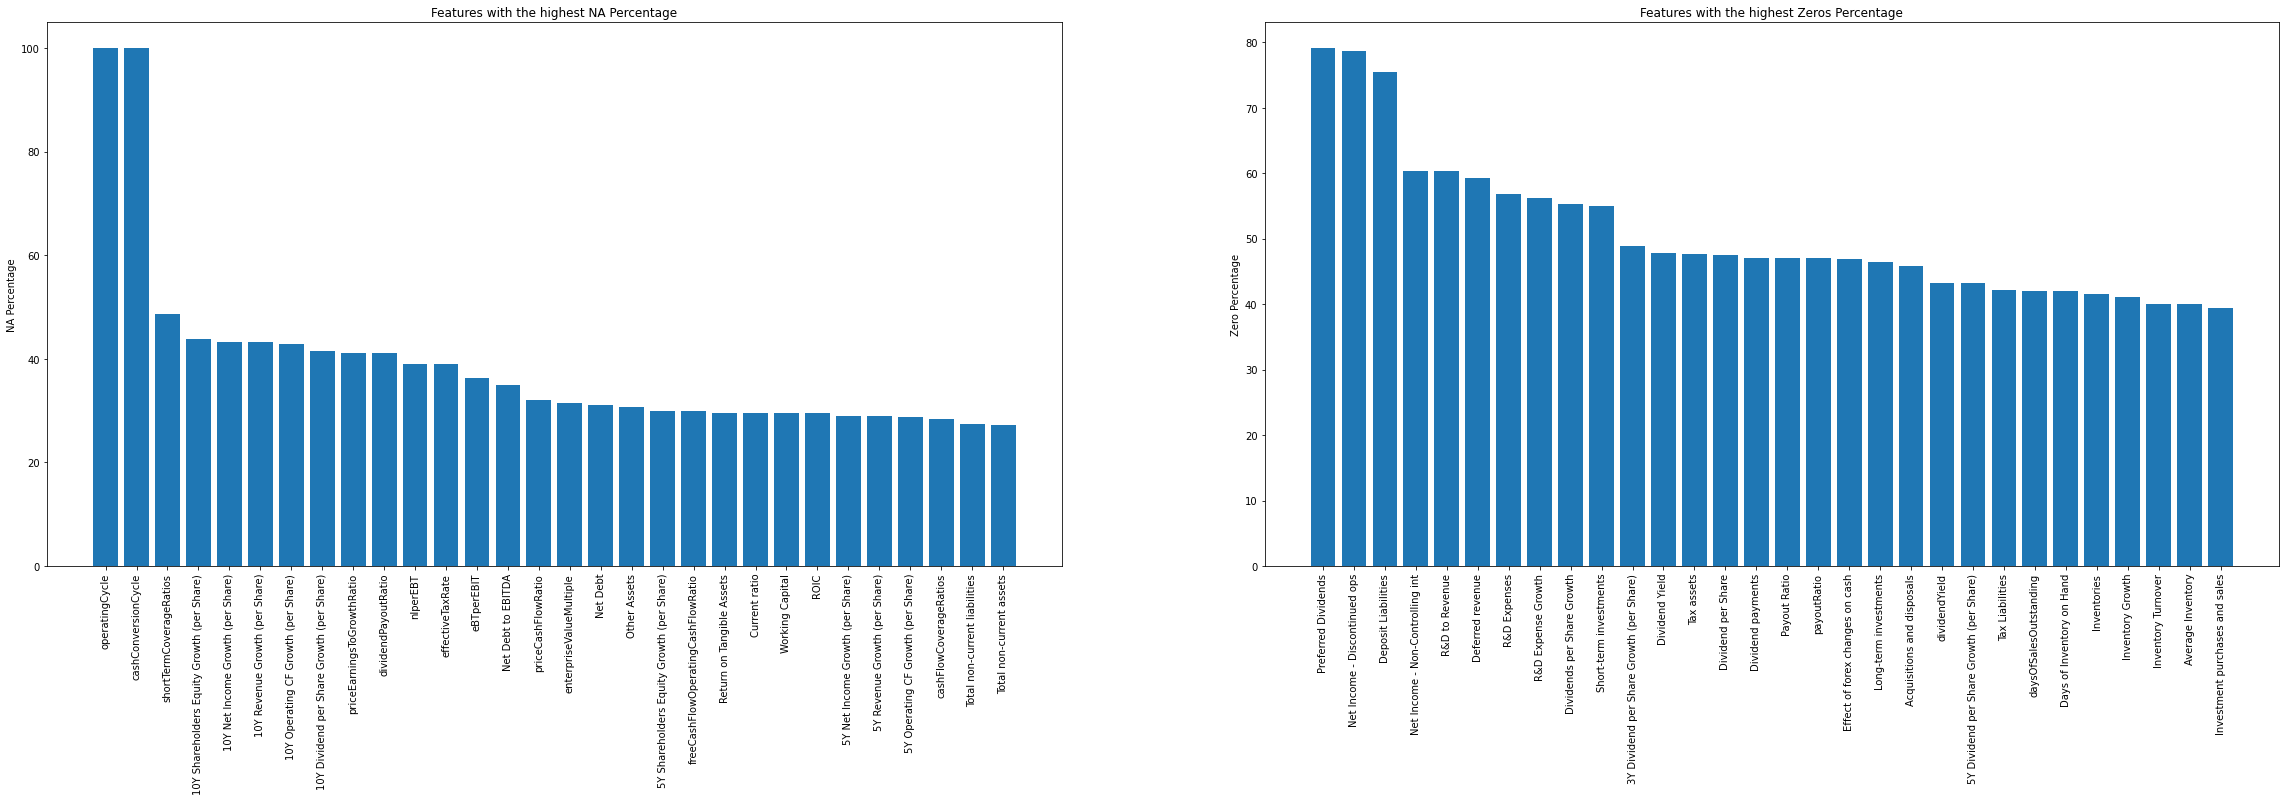

In [11]:
############## Nas and Zeros in the Dataset ##############
## Calculating the Percentage of NAs/Zeros
# Percentage of NAs:
na_percent = (findata.isna().sum()/findata.shape[0]*100).sort_values(ascending = False)
# Percentage of Zeros of all columns but response Class:
zero_percent = (findata.loc[:, findata.columns != "Class"].isin([0]).sum()/findata.shape[0]*100).sort_values(ascending = False)

## Plotting the Results
fig, ax = plt.subplots(nrows = 1, ncols = 2 , figsize=(40, 10))
ax = ax.ravel()

na_labels = na_percent[0:30].index.values.tolist()
ax[0].bar(np.arange(30), na_percent[0:30].values.tolist())
ax[0].set_xticks(np.arange(30))
ax[0].set_ylabel("NA Percentage")
ax[0].set_xticklabels(na_labels, rotation=90)
ax[0].set_title("Features with the highest NA Percentage")

zero_labels =  zero_percent[0:30].index.values.tolist()
ax[1].bar(np.arange(30), zero_percent[0:30].values.tolist())
ax[1].set_xticks(np.arange(30))
ax[1].set_ylabel("Zero Percentage")
ax[1].set_xticklabels(zero_labels, rotation=90)
ax[1].set_title("Features with the highest Zeros Percentage")

## Convert 0s to NAs
findata.loc[:,findata.columns != "Class"] = findata.loc[::, findata.columns != "Class"].replace({"0" : np.nan, 0 : np.nan})
print(findata["Preferred Dividends"].head(5), findata["Class"].head()) # making sure it has worked

Next we set a threshold for the NA proportion so that columns get removed if their NA proportion is higher. To choose the right threshold we tried out different values and compared the performance of our models using the respective threshold whilst considering the number of features that get removed. We decided to use 0.3 since it yielded approximately the same performance as lower values e.g. 0.2 all whilst keeping a lot more features. Interestingly, setting the threshold to a very low number like 0.1 greatly worsened the performance of our model since too many features got removed. Too high of a value was not good either probably because in this case the imputed values were too far-fetched.

In [12]:
############## NA Threshold ##############
na_threshold = 0.3 # threshold for NA percentage
print(sum(findata.isna().mean() > na_threshold)) # 76 of the remaining variables have more than 30% NAs
findata = findata.loc[::, findata.isna().mean() < na_threshold] # drop all columns with NA proportion higher than threshold
print(findata[["Class", "Sector"]].dtypes)
findata.shape

76
Class      int64
Sector    object
dtype: object


(22077, 144)

To apply our machine learning algorithms we need to encode our categorical variables. For this we first have a look at the amount of unique values of each column:

Text(0.5, 1.0, '20 Columns with Lowest Count of Unique Values')

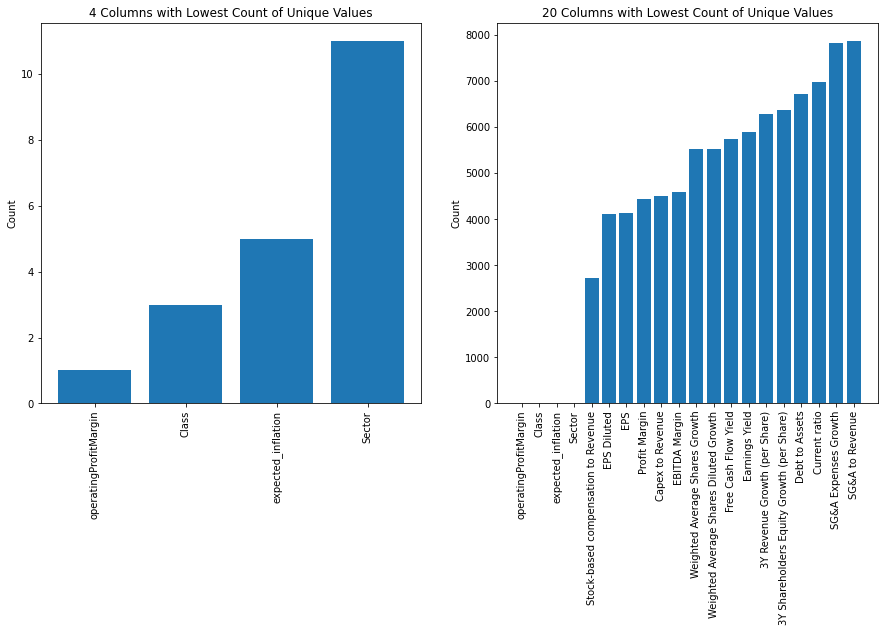

In [13]:
############## Unique Value Count Plots ##############
fig, ax = plt.subplots(nrows = 1, ncols = 2 , figsize=(15, 7))
ax = ax.ravel()
fin_unique4 = findata.nunique().nsmallest(n = 4) # 4 columns with least unique values
fin_unique4_labels = fin_unique4.index.values.tolist()
ax[0].bar(np.arange(4), fin_unique4.values.tolist())
ax[0].set_xticks(np.arange(4))
ax[0].set_ylabel("Count")
ax[0].set_xticklabels(fin_unique4_labels, rotation=90)
ax[0].set_title("4 Columns with Lowest Count of Unique Values")

fin_unique20 = findata.nunique().nsmallest(n = 20) # 20 columns with least unique values
fin_unique20_labels = fin_unique20.index.values.tolist()
ax[1].bar(np.arange(20), fin_unique20.values.tolist())
ax[1].set_xticks(np.arange(20))
ax[1].set_ylabel("Count")
ax[1].set_xticklabels(fin_unique20_labels, rotation=90)
ax[1].set_title("20 Columns with Lowest Count of Unique Values")

Further investigation shows that only two of these columns with the lowest count of unique values need to be converted to dummy variables/ one-hot-encoded: Class and Sector. The variable operatingProfitMargin can be dropped since it is a column consisting only of the value 1. After this is all said and done, we can finally split our data into a train and a test set. 

In [14]:
############## Train-Test Split ##############
# Drop operatingProfitMargin:
findata = findata.drop(["operatingProfitMargin"], axis = 1)
## Convert Sector& Class to Factors
# create dummies in place of the original Sector variable each with the prefix "Sector" in its variable name
findata = pd.concat([findata, pd.get_dummies(findata["Sector"], prefix="Sector")],axis=1).drop(["Sector"],axis=1) 
# encode response variable
label_encoder  = pp.LabelEncoder()
findata["Class"] = label_encoder.fit_transform(findata["Class"])
print(findata.iloc[:,-15:].head(3))
print(findata.shape)
X = findata.drop(["Class", "excess_return", "PRICE VAR [%]", "cashflow_margin", "operating_liabilities", "NIC", "RONA", "expected_inflation"], axis = 1) 
# all columns but response Class, the variables we needed to classify the stocks and our own features
y = findata['Class']
print(y.value_counts()) # Upsampling required (but only after train-test split)

## Train-Test Split
# To impute the missing values we need to first split the data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.1, random_state = 42) # Train-Test Split 90:10 for large datasets according to Script/ Raschka (2015)
# Print proportions of each class in the train set
print(f"Sell proportion:  {sum(y_train ==0)/X_train.shape[0]: .6f}")
print(f"Hold proportion:  {sum(y_train ==1)/X_train.shape[0]: .6f}")
print(f"Buy proportion: {sum(y_train ==2)/X_train.shape[0]: .6f}")


      operating_liabilities           NIC      RONA  expected_inflation  \
PG             3.887300e+10  1.357080e+11  0.112027                2015   
VIPS           1.678719e+09  1.963172e+09  0.095524                2015   
KR             1.257600e+10  2.888000e+10  0.093940                2015   

      Sector_Basic Materials  Sector_Communication Services  \
PG                         0                              0   
VIPS                       0                              0   
KR                         0                              0   

      Sector_Consumer Cyclical  Sector_Consumer Defensive  Sector_Energy  \
PG                           0                          1              0   
VIPS                         0                          1              0   
KR                           0                          1              0   

      Sector_Financial Services  Sector_Healthcare  Sector_Industrials  \
PG                            0                  0                 

As we can see our data is extremely imbalanced. Thus we decided to later on use upsampling to deal with said imbalances. For upsampling we first agreed upon using SMOTE (Synthetic Minority Oversampling TEchnique) which contrary to upsampling using the resample() function creates new, additional observations that increase the variation within the data and thus provides additional information to the model. The biggest problem with using SMOTE() was that the newly created samples of the categorical variables are numerical and not categorical. To make sure categorical variables stay categorical there would exist the SMOTENC() function that requires the categorical variables to not be one-hot-encoded. Since we had to one-hot-encode the Sector variable to apply the KNN imputer we decided to use neither from the SMOTE functions. Note that just dropping the Sector variable was not an option since we observed a significant drop in performance when doing so (can also be seen in Feature importance plot). Instead we used RandomOverSampler of the imblearn package. The biggest advantage of RandomOverSampler over resample is that it can be easily introduced as a step in a pipeline. It is important to note that the pipeline implementation does not work using the sklearn pipeline but one has to use the imblearn pipeline instead. The biggest advantage of this pipeline implementation is that this way the k-fold cross validation train scores are closer to test scores. 

In [15]:
############## Imputation of Missing Values##############
# This code block may take some minutes to execute.
# First use X_train to fit the imputer, then apply it to X_train and X_test
# Important: We DO NOT use X_test to fit the imputer seperately
imputer = KNNImputer(n_neighbors = 5, weights = "distance")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
print("NAs remaining: ", sum(isnan(X_train).flatten()))
print("NAs remaining: ", sum(isnan(X_test).flatten()))

NAs remaining:  0
NAs remaining:  0


We have learnt in the lecture that decision tree algorithms are insensitive to the data's magnitude unlike other algorithms like e.g. PCA or SVM. Consequently, there exists a decision tree algorithm called Isolation Forest that can detect anomalies/ outliers in the data. Below we make use of this algorithm:

In [16]:
############## Outlier Detection ##############
## Isolation Forest
outliers = IsolationForest(random_state = 42).fit(X_train) # fit Isolation Forest only to training data
outliers_train = outliers.predict(X_train)
outliers_test = outliers.predict(X_test)

## Remove outliers where 1 represent inliers and -1 represent outliers:
X_train_cleaned = X_train[np.where(outliers_train == 1, True, False)]
y_train_cleaned = y_train[np.where(outliers_train == 1, True, False)]
X_test_cleaned = X_test[np.where(outliers_test == 1, True, False)]
y_test_cleaned = y_test[np.where(outliers_test == 1, True, False)]
print("Shape with outliers: ", X_train.shape,", Shape without outliers: ", X_train_cleaned.shape,", Removed outliers: ", X_train.shape[0]-X_train_cleaned.shape[0])
print("Shape with outliers: ", X_test.shape,", Shape without outliers: ", X_test_cleaned.shape,", Removed outliers: ", X_test.shape[0]-X_test_cleaned.shape[0]) 

## Print proportions of each class in cleaned data set
sell_prop_trainc = sum(y_train_cleaned == 0)/X_train_cleaned.shape[0]
hold_prop_trainc = sum(y_train_cleaned == 1)/X_train_cleaned.shape[0]
buy_prop_trainc = sum(y_train_cleaned == 2)/X_train_cleaned.shape[0]
print(f"Sell proportion:  {sell_prop_trainc: .6f}")
print(f"Hold proportion:  {hold_prop_trainc: .6f}")
print(f"Buy proportion:  {buy_prop_trainc: .6f}")

Shape with outliers:  (19869, 145) , Shape without outliers:  (19653, 145) , Removed outliers:  216
Shape with outliers:  (2208, 145) , Shape without outliers:  (2179, 145) , Removed outliers:  29
Sell proportion:   0.510609
Hold proportion:   0.048033
Buy proportion:   0.441358


Text(0.5, 1.0, 'Correlation Heatmap')

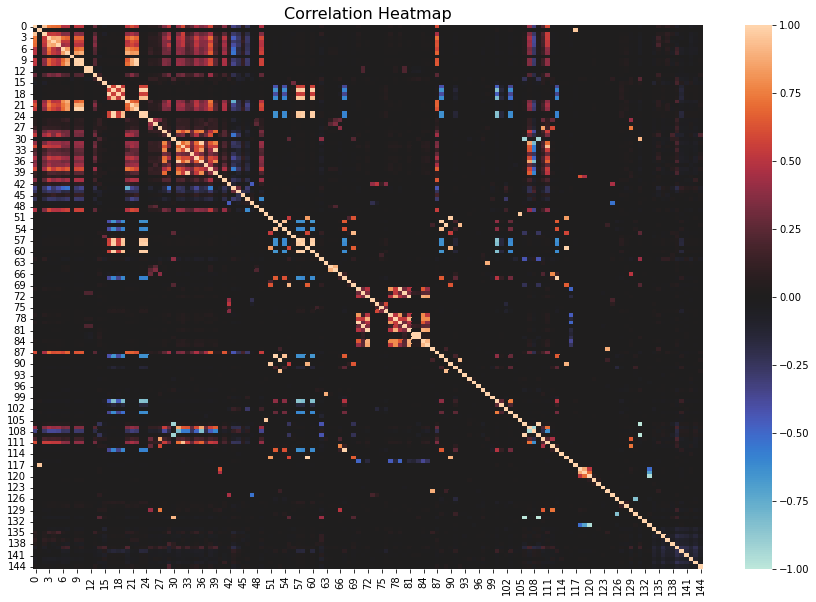

In [17]:
############## Correlation Matrix ##############
corr = pd.DataFrame(X_train_cleaned).corr()
plt.figure(figsize=(15,10)) 
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, center = 0) # heatmap of correlation
heatmap.set_title("Correlation Heatmap", fontdict={"fontsize":16})

We can see that few of the features are highly positive/ negative correlated but many are only barely correlated. Thus, there might be some problems with (linear) PCA since we have many variables that are hardly correlated. Note that correlation only measures the **linear** relationship between the variables and the variables might be dependent in a non-linear way like it is the case with e.g. ratios.  Hence, a non linear dimension reduction approach like e.g. Sigmoid Kernel PCA might yield better results.

In [18]:
############## Preparations for Model Fitting ##############
## k-fold Cross Validation
kFold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
# 5 splits since findata is a large dataset (see script)
## Standardizing
ros = RandomOverSampler(random_state = 42)
scaler = StandardScaler()
mms = MinMaxScaler()

## Feature Selection using Random Forest for outside of pipeline
forest = RandomForestClassifier(random_state = 42)
select_rf = SelectFromModel(estimator = forest, threshold = "median")
select_rf.fit(X_train_cleaned, y_train_cleaned)
X_train_rf = X_train_cleaned:, select_rf.get_support()]
X_test_rf = X_test_cleaned[:, select_rf.get_support()]

## Feature Selection using XGBoost for outside of pipeline
xgbc= xgb.XGBClassifier(tree_method = "gpu_hist", objective = "multi:softmax", random_state = 42)
select_xgbc = SelectFromModel(estimator = xgbc, threshold = "median")
select_xgbc.fit(X_train_cleaned, y_train_cleaned)
X_train_xgbc = X_train_cleaned[:, select_xgbc.get_support()]
X_test_xgbc = X_test_cleaned[:, select_xgbc.get_support()]

To plot the relative importance of our features we define a function that can also be found on pages 147-148 of the script.

In [47]:
############## Feature Importance Plot ##############
def plot_FI(model, X, n, X_train_cleaned, y_train_cleaned):
  """
  Inputs required: model (xgboost/ random forest), X dataframe, number of features, cleaned X_train, cleaned y_train
  Function to plot n most important features and their cumulative, relative feature importance
  """
  feat_labels = X.columns[::-1]  
  model.fit(X_train_cleaned , y_train_cleaned )
  importances = model.feature_importances_
  indices = np.argsort(importances)[:: -1]
  n = 20
  for i in range(n):
    print('{0:2d} {1:7s} {2:6.4f}'.format(i+1,feat_labels[indices[i]],importances[indices[i]]))

  feat_imp = np.sort(importances)[::-1]
  sum_feat_imp = np.cumsum(feat_imp)[:n]

  plt.figure(figsize =(12, 8))
  plt.bar(range(n),importances[indices[:n]],align = "center")
  plt.xticks (range(n),feat_labels[indices[:n]],rotation =90)
  plt.xlim ([-1,n])
  plt.xlabel("Feature")
  plt.ylabel("Rel.Feature Importance")
  plt.step(range(n),sum_feat_imp,where="mid", label = "Cumulative importance")
  plt.tight_layout();

 1 Net Cash/Marketcap 0.0110
 2 Weighted Average Shs Out 0.0101
 3 Current ratio 0.0099
 4 Free Cash Flow margin 0.0096
 5 Weighted Average Shs Out (Dil) 0.0094
 6 EBITDA  0.0094
 7 Profit Margin 0.0093
 8 Gross Margin 0.0093
 9 Debt to Equity 0.0091
10 EPS     0.0091
11 EBIT Margin 0.0091
12 Sector_Technology 0.0090
13 Sector_Consumer Cyclical 0.0089
14 Enterprise Value 0.0087
15 Receivables 0.0087
16 Free Cash Flow growth 0.0086
17 EBITDA Margin 0.0086
18 EBIT    0.0086
19 Consolidated Income 0.0086
20 priceSalesRatio 0.0086


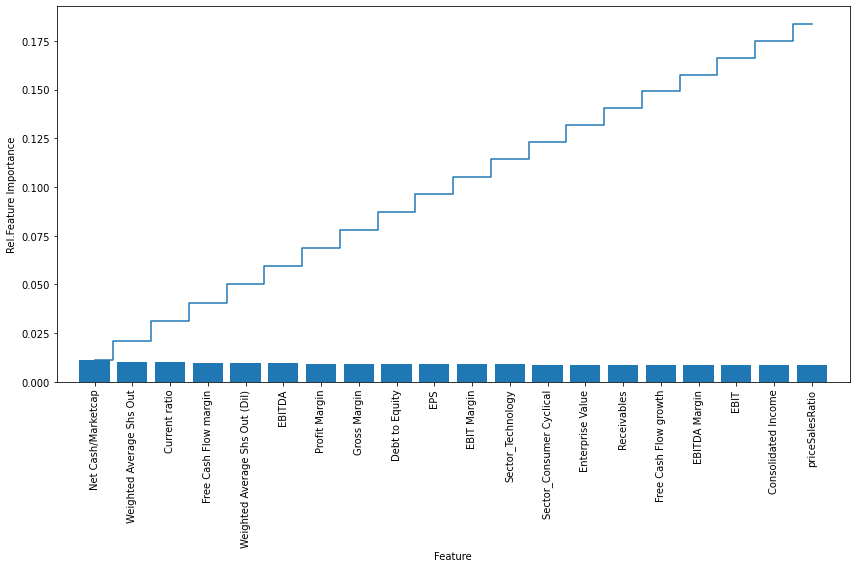

In [48]:
############## Feature Importance: Random Forest ##############
forest = RandomForestClassifier(random_state = 42)
plot_FI(forest, X, 20, X_train_cleaned, y_train_cleaned)

XGBoost Feature Importance plot to compare:

 1 Market Cap 0.0714
 2 companyEquityMultiplier 0.0578
 3 Shareholders Equity per Share 0.0396
 4 Free Cash Flow growth 0.0272
 5 Graham Net-Net 0.0176
 6 Operating Income 0.0168
 7 Book Value per Share Growth 0.0154
 8 Free Cash Flow per Share 0.0149
 9 Current ratio 0.0148
10 totalDebtToCapitalization 0.0137
11 Capex to Depreciation 0.0130
12 Net Cash/Marketcap 0.0115
13 cashPerShare 0.0101
14 Receivables 0.0100
15 Earnings Before Tax Margin 0.0097
16 priceSalesRatio 0.0094
17 EPS Growth 0.0092
18 Book Value per Share 0.0087
19 Total assets 0.0087
20 Cash per Share 0.0082


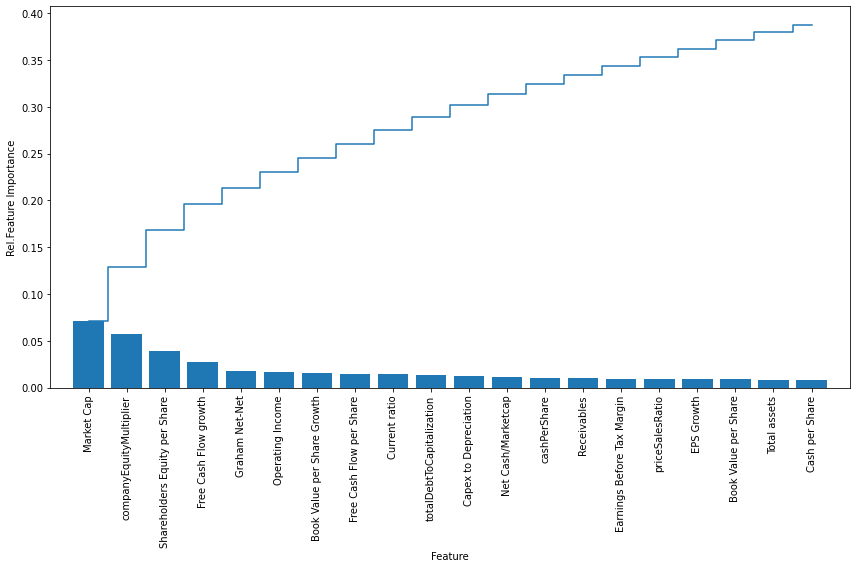

In [49]:
############## Feature Importance: XGBoost ##############
xgbc = xgb.XGBClassifier(tree_method = "gpu_hist", objective = "multi:softmax", random_state = 42)
plot_FI(xgbc, X, 20, X_train_cleaned, y_train_cleaned)

## Model Fitting

### Performance Metric
For scoring our models we will be using the weighted $F_1$-Score.

In [19]:
############## Report Functions ##############
# Function to get best parametrs, mean cross-validation score of best parameters, standard deviation of the cross-validation scores of the best parameters
# and the score of the test set
def get_results_cv(func, X_test_cleaned, y_test_cleaned):
  """
  Inputs required: already fitted gridsearcv or randomsearchcv function, cleaned X test set, cleaned y test set
  Returns best parameters, mean score, sd of score of cross-validation. Also returns test-score of best parameters
  """
  std_best_score = func.cv_results_["std_test_score"][func.best_index_]
  print(f"Best parameters: {func.best_params_}")
  print(f"Mean CV score: {func.best_score_: .6f}")
  print(f"Standard deviation of CV score: {std_best_score: .6f}")
  print("Test Score: {:.6f}".format(func.score(X_test_cleaned, y_test_cleaned)))

# Function to get metrics report and heatmap of the confusion matrics for the test set
def final_report(y_true, y_pred):
  """
  Inputs required: true classes, predicted classes
  Returns classification report and confusion matrix of the model
  """
  class_report = metrics.classification_report(y_true, y_pred)
  print(class_report)
  cm = confusion_matrix(y_true, y_pred, normalize = "all")
  cm = pd.DataFrame(cm, ["Sell", "Hold", "Buy"], ["Sell", "Hold", "Buy"])
  plt.figure(figsize = (10,5))
  sns.heatmap(cm, annot = True, fmt = ".2%", cmap = "Blues").set(xlabel = "Assigned Class", ylabel = "True Class", title = "Confusion Matrix")

In [ ]:
?get_results_cv

In [ ]:
?final_report

In [47]:
############## Ignore Filterwarnings ##############
# to avoid "UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples." spam
# for models where some element(s) in the confusion matrix is/are 0
warnings.filterwarnings("ignore") 

### Naive Classification/ Baseline

Test Score:   0.465576
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      1114
           1       0.04      0.05      0.05       103
           2       0.45      0.46      0.45       962

    accuracy                           0.46      2179
   macro avg       0.34      0.34      0.34      2179
weighted avg       0.47      0.46      0.47      2179



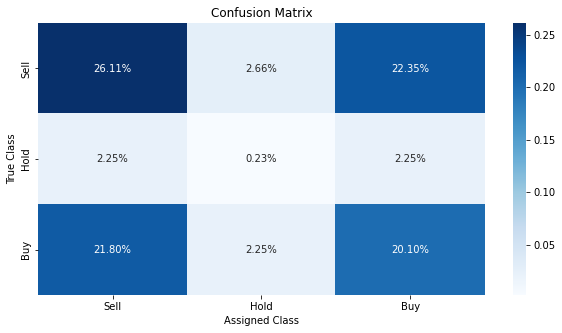

In [20]:
############## Naive Classification/ Baseline ##############
priors = [sell_prop_trainc, hold_prop_trainc, buy_prop_trainc]
np.random.seed(42) # set seed
# randomly choose classes 0, 1, 2 with probabilities based on proportions from X_train_cleaned
y_pred = np.random.choice([0, 1, 2], size = len(y_test_cleaned), replace = True, p = priors) 

f1_weighted = metrics.f1_score(y_test_cleaned, y_pred, average = "weighted")
print(f"Test Score:  {f1_weighted: .6f}")
final_report(y_test_cleaned, y_pred)

### Logistic Regression

Parameters of the logistic regression : dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])
Best parameters: {'classifier__C': 6, 'classifier__penalty': 'l2', 'ros': None, 'scaler': StandardScaler()}
Mean CV score:  0.506191
Standard deviation of CV score:  0.006042
Test Score: 0.508246
              precision    recall  f1-score   support

           0       0.55      0.77      0.64      1114
           1       0.00      0.00      0.00       103
           2       0.53      0.34      0.41       962

    accuracy                           0.54      2179
   macro avg       0.36      0.37      0.35      2179
weighted avg       0.51      0.54      0.51      2179



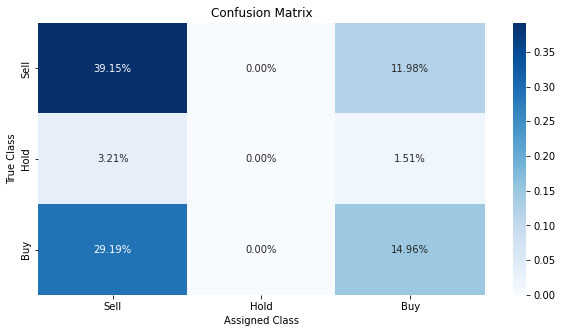

In [ ]:
############## Logistic Regression ##############

####################
### All Features ###
####################
logistic = LogisticRegression(random_state=42, max_iter=20, n_jobs=-1) # initialize logistic regression classifier
# Get hyperparameter names for logistic regression:
print(f"Parameters of the logistic regression : {logistic.get_params().keys()}")

# Set up pipeline
pipe = imbpipeline(steps=[["scaler", scaler], ["ros", ros], ["classifier", logistic]])
# Set up parameter grid with hyperparameters we want to tune
param_grid = {'ros': [ros, None], # upsampling or not
              'scaler': [scaler, None, mms], # scaling input by standardizing or min-max scaling or not scaling at all
              'classifier__C': [1, 6, 7, 8, 9, 10],
              'classifier__penalty': [None, 'l2', 'l1', 'elasticnet']}
# Conduct grid search with cross-validation to find hyperparameters that yield the best score
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
# Fit using the best parameters
gs = gs.fit(X_train_cleaned, y_train_cleaned)

# get results of cross-validation
get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'ros': RandomOverSampler(random_state=42), 'scaler': StandardScaler()}
Mean CV score:  0.440289
Standard deviation of CV score:  0.009709
Test Score: 0.439537
              precision    recall  f1-score   support

           0       0.54      0.50      0.52      1114
           1       0.07      0.37      0.12       103
           2       0.48      0.32      0.38       962

    accuracy                           0.41      2179
   macro avg       0.36      0.40      0.34      2179
weighted avg       0.49      0.41      0.44      2179



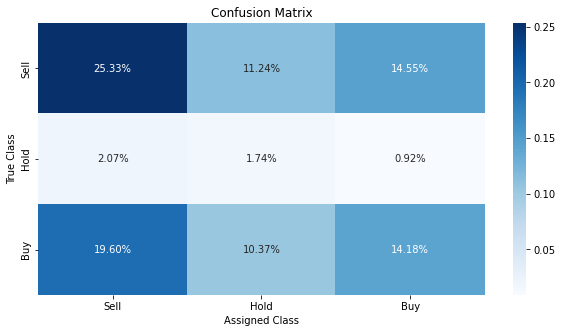

In [ ]:
############## Logistic Regression ##############

########################################
### Random Forest Feature Selection ###
########################################
forest = RandomForestClassifier(random_state = 42) # initialize random forest
pipe = imbpipeline(steps=[["scaler", scaler], ["feature_selection",  SelectFromModel(estimator = forest, threshold = "median")],
                          ["ros", ros], ["classifier", logistic]])

param_grid = {'ros': [ros, None],
              'scaler': [scaler, mms, None],
              'classifier__C': [1, 6, 7, 8, 9, 10],
              'classifier__penalty': [None, 'l2', 'l1', 'elasticnet']}

gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)


Best parameters: {'classifier__C': 6, 'classifier__penalty': 'l2', 'ros': None, 'scaler': StandardScaler()}
Mean CV score:  0.462492
Standard deviation of CV score:  0.011105
Test Score: 0.466468
              precision    recall  f1-score   support

           0       0.53      0.84      0.65      1114
           1       0.00      0.00      0.00       103
           2       0.51      0.22      0.30       962

    accuracy                           0.53      2179
   macro avg       0.35      0.35      0.32      2179
weighted avg       0.50      0.53      0.47      2179



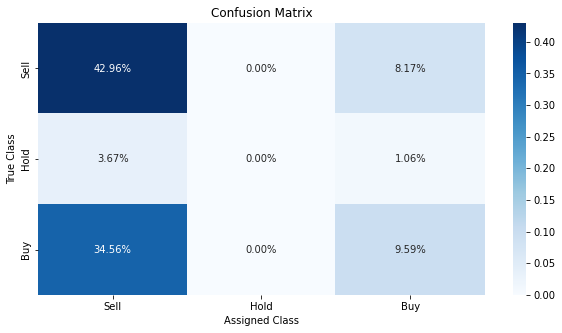

In [ ]:
############## Logistic Regression ##############

#################################
### XGBoost Feature Selection ###
#################################
xgbc= xgb.XGBClassifier(tree_method = "gpu_hist", objective = "multi:softmax", random_state = 42)
pipe = imbpipeline(steps=[["scaler", scaler], ["feature_selection",  SelectFromModel(estimator = xgbc, threshold = "median")],
                          ["ros", ros], ["classifier", logistic]])

param_grid = {'ros': [ros, None],
              'scaler': [scaler, mms, None],
              'classifier__C': [1, 6, 7, 8, 9, 10],
              'classifier__penalty': [None, 'l2', 'l1', 'elasticnet']}

gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)


Best parameters: {'classifier__C': 9, 'kpca__kernel': 'sigmoid', 'kpca__n_components': 6}
Mean CV score:  0.436620
Standard deviation of CV score:  0.006342
Test Score: 0.449612
              precision    recall  f1-score   support

           0       0.58      0.40      0.48      1114
           1       0.07      0.38      0.12       103
           2       0.48      0.43      0.45       962

    accuracy                           0.41      2179
   macro avg       0.38      0.40      0.35      2179
weighted avg       0.52      0.41      0.45      2179



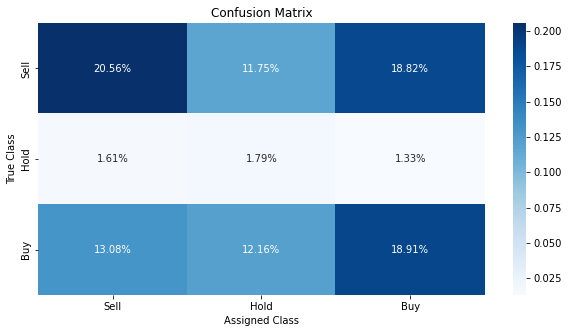

In [ ]:
############## Logistic Regression ##############

######################################
### Kernel PCA Dimension Reduction ###
######################################
logistic = LogisticRegression(random_state=42, max_iter=20, n_jobs=-1)
kpca = KernelPCA(random_state = 42, eigen_solver = "arpack")
pipe = imbpipeline(steps=[["scaler", scaler], ["kpca",  kpca],
                          ["ros", ros], ["classifier", logistic]])

param_grid = {'kpca__n_components': np.arange(5, 10, 1),
              #linear is the "normal" PCA we have discussed in the lecture
              #only consider linear and sigmoid since we have ran it before and saw that sigmoid normally performed better than poly and rbf
              "kpca__kernel": ["linear", "sigmoid"],
              'classifier__C': [1, 6, 7, 8, 9, 10]}
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'classifier__penalty': 'l2', 'ros': None, 'scaler': StandardScaler()}
Mean CV score:  0.467739
Standard deviation of CV score:  0.014068
Test Score: 0.456001
              precision    recall  f1-score   support

           0       0.52      0.77      0.62      1114
           1       0.00      0.00      0.00       103
           2       0.46      0.24      0.32       962

    accuracy                           0.50      2179
   macro avg       0.32      0.34      0.31      2179
weighted avg       0.47      0.50      0.46      2179



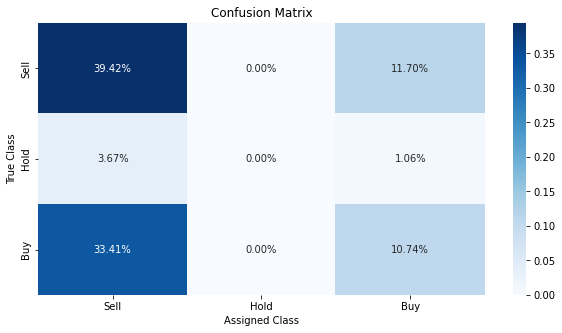

In [ ]:
############## Logistic Regression ##############

######################################
### Kernel PCA Finetuning ###
######################################
logistic = LogisticRegression(random_state=42, max_iter=20, n_jobs=-1, C = 9)
kpca = KernelPCA(random_state = 42, eigen_solver = "arpack", n_components = 6, kernel = "sigmoid")
pipe = imbpipeline(steps=[["scaler", scaler], ["kpca",  kpca],
                          ["ros", ros], ["classifier", logistic]])

param_grid = {'ros': [ros, None],
              'scaler': [scaler, mms, None],
              'classifier__penalty': [None, 'l2', 'l1', 'elasticnet']}
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

We can see that the logistic regression using all features but no dimension reduction or feature selection tool performed the best and achieved a test $F_1$-Score of 0.51. Noteworthy is that the model achieved this score by standardizing the input but **without upsampling** it.

### (Gaussian) Naive Bayes Classifier
Fun fact: LDA is a special case of a naive Bayes classifier.

Parameters of the Gaussian Naive Bayes: dict_keys(['priors', 'var_smoothing'])
Best parameters: {'gnb__priors': None, 'gnb__var_smoothing': 0.19630406500402708, 'ros': None, 'scaler': None}
Mean CV score:  0.353743
Standard deviation of CV score:  0.002588
Test Score: 0.358319
              precision    recall  f1-score   support

           0       0.51      0.98      0.68      1114
           1       0.10      0.02      0.03       103
           2       0.59      0.01      0.03       962

    accuracy                           0.51      2179
   macro avg       0.40      0.34      0.24      2179
weighted avg       0.53      0.51      0.36      2179



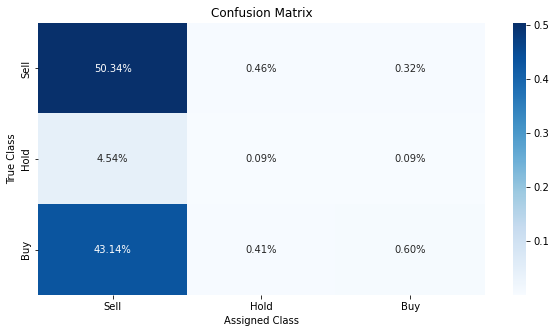

In [ ]:
############## Naive Bayes ##############

####################
### All Features ###
####################
gnb = GaussianNB()
print(f"Parameters of the Gaussian Naive Bayes: {gnb.get_params().keys()}")

pipe = imbpipeline(steps=[["scaler", scaler], ["ros", ros], ["gnb", gnb]])
param_grid= {
    "scaler": [scaler, None],
    "ros": [ros, None],
    "gnb__priors": [None, priors], # priors are either None or proportion of classes in train set calculated above
    "gnb__var_smoothing": np.logspace(0, -10, num = 100),
}

gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)


get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'gnb__priors': [0.5106090673179667, 0.048033379127868515, 0.4413575535541648], 'gnb__var_smoothing': 0.0774263682681127, 'ros': RandomOverSampler(random_state=42), 'scaler': MinMaxScaler()}
Mean CV score:  0.393061
Standard deviation of CV score:  0.013442
Test Score: 0.389658
              precision    recall  f1-score   support

           0       0.52      0.90      0.66      1114
           1       0.06      0.07      0.06       103
           2       0.48      0.06      0.11       962

    accuracy                           0.49      2179
   macro avg       0.35      0.34      0.28      2179
weighted avg       0.48      0.49      0.39      2179



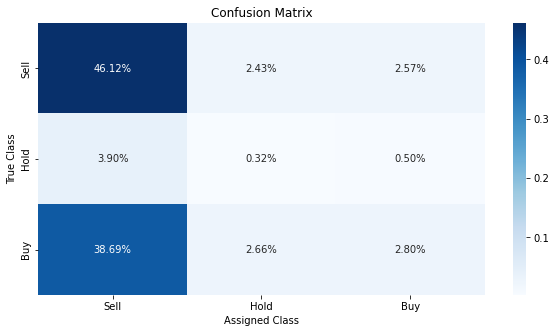

In [ ]:
############## Naive Bayes ##############

########################################
### Random Forest Feature Selectionn ###
########################################
forest = RandomForestClassifier(random_state = 42)
pipe = imbpipeline(steps=[["scaler", scaler], ["feature_selection",  SelectFromModel(estimator = forest, threshold = "median")],
                          ["ros", ros], ["gnb", gnb]])

param_grid= {
    "scaler": [scaler, mms, None],
    "ros": [ros, None],
    "gnb__priors": [None, priors], 
    "gnb__var_smoothing": np.logspace(0, -10, num = 10),
}
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'gnb__priors': [0.5106090673179667, 0.048033379127868515, 0.4413575535541648], 'gnb__var_smoothing': 0.0774263682681127, 'ros': None, 'scaler': MinMaxScaler()}
Mean CV score:  0.458714
Standard deviation of CV score:  0.012412
Test Score: 0.504692
              precision    recall  f1-score   support

           0       0.54      0.67      0.60      1114
           1       0.00      0.00      0.00       103
           2       0.49      0.41      0.45       962

    accuracy                           0.52      2179
   macro avg       0.35      0.36      0.35      2179
weighted avg       0.50      0.52      0.50      2179



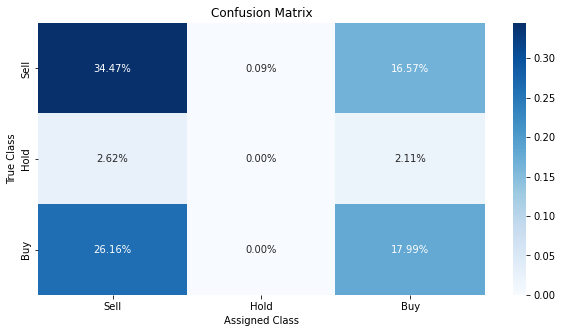

In [ ]:
############## Naive Bayes ##############

#################################
### XGBoost Feature Selection ###
#################################
xgbc= xgb.XGBClassifier(tree_method = "gpu_hist", objective = "multi:softmax", random_state = 42)
pipe = imbpipeline(steps=[["scaler", scaler], ["feature_selection",  SelectFromModel(estimator = xgbc, threshold = "median")],
                          ["ros", ros], ["gnb", gnb]])

param_grid= {
    "scaler": [scaler, mms, None],
    "ros": [ros, None],
    "gnb__priors": [None, priors], 
    "gnb__var_smoothing": np.logspace(0, -10, num = 10),
}
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

The idea of Kernel PCA is to extend PCA to the non-linear case. For this we transform our variables X by applying a non-linear function $\varphi_k(\cdot)$ to X and then in a second step apply PCA to the transformed variables. Instead of doing an eigendecomposition of the variance-covariance matrix it can be shown that this problem is equivalent to solving $K\tilde{\alpha}=\tilde{\lambda}\tilde{\alpha}$ where K is a Kernel function (K has to be continuous, symmetric and positive-definite). Once we have $(\tilde{\alpha},\tilde{\lambda})$ we can obtain the eigenvalues& eigenvectors of the original problem. When using Kernel PCA the computational complexity only depends on the number of samples n and not of the number of features since K is a $n\times n$ matrix. Because we upsample in our pipeline the dimension of this matrix K quickly gets out of hand. Thus we decided to use RandomizedSearchCV to get a broad idea of the magnitude of the hyperparameters. Subsequently, we'll finetune these parameters using GridSearchCV. On a site note, there also exists the experimental [HalfGridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html) and [HalfRandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) that take an iterative approach and are supposed to yield similar results while being a lot faster. But from what we've gathered the accuracy and execution time strongly depends on the parameter choice of these Half functions and thus we decided to stay on familiar ground and use RandomizedSearchCV and GridSearchCV instead.

Best parameters: {'kpca__n_components': 8, 'kpca__kernel': 'sigmoid', 'kpca__gamma': 0.0077777777777777776, 'kpca__coef0': 0.8}
Mean CV score:  0.501877
Standard deviation of CV score:  0.009886
Test Score: 0.507606
              precision    recall  f1-score   support

           0       0.55      0.66      0.60      1114
           1       0.11      0.05      0.07       103
           2       0.50      0.41      0.45       962

    accuracy                           0.52      2179
   macro avg       0.38      0.37      0.37      2179
weighted avg       0.51      0.52      0.51      2179



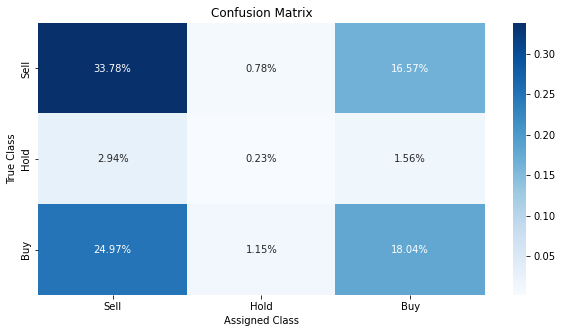

In [ ]:
############## Naive Bayes ##############

##################
### Kernel PCA ###
##################
gnb = GaussianNB(priors = priors)
kpca = KernelPCA(random_state = 42, eigen_solver = "arpack", n_jobs = -1)
# We used arpack since randomized requires matrix to be positive (semi-)definite
gnb_pipe = imbpipeline(steps=[["scaler", scaler], ["kpca", kpca], ["ros", ros], ["gnb", gnb]])
random_grid = {
    "kpca__n_components": np.arange(4, 10, 1),
    "kpca__kernel": ["linear", "sigmoid"], #linear is the "normal" PCA we have discussed in the lecture; only consider linear and sigmoid since we have ran it before and saw that sigmoid performed better than poly and rbf
    "kpca__gamma": np.linspace(0.005, 0.01, 10),
    "kpca__coef0": np.linspace(0.8, 1.2, 10),
}


rs = RandomizedSearchCV(estimator = gnb_pipe, param_distributions = random_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1, n_iter = 100, random_state = 42, error_score = "raise")

rs = rs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(rs, X_test_cleaned, y_test_cleaned)
y_pred = rs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'gnb__priors': [0.5106090673179667, 0.048033379127868515, 0.4413575535541648], 'gnb__var_smoothing': 2.782559402207126e-06, 'ros': RandomOverSampler(random_state=42), 'scaler': StandardScaler()}
Mean CV score:  0.501877
Standard deviation of CV score:  0.009886
Test Score: 0.507606
              precision    recall  f1-score   support

           0       0.55      0.66      0.60      1114
           1       0.11      0.05      0.07       103
           2       0.50      0.41      0.45       962

    accuracy                           0.52      2179
   macro avg       0.38      0.37      0.37      2179
weighted avg       0.51      0.52      0.51      2179



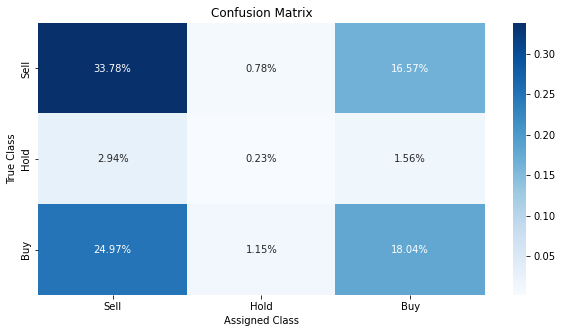

In [ ]:
############## Naive Bayes ##############

#############################
### Kernel PCA Finetuning ###
#############################

kpca_gnb_ft = KernelPCA(random_state = 42, gamma = 0.0077777777777777776, coef0 = 0.8,
                        kernel = "sigmoid", n_components = 8, eigen_solver = "arpack", n_jobs = -1)
gnb = GaussianNB(var_smoothing = 1.6681005372000556e-08)
pipe = imbpipeline(steps=[["scaler", scaler], ["kpca", kpca_gnb_ft], ["ros", ros], ["gnb", gnb]])

param_grid = {
    "scaler": [None, mms, scaler],
    "ros": [None, ros],
    "gnb__priors": [None, priors],
    "gnb__var_smoothing": np.logspace(0, -10, 10)
}

gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Gaussian Naive Bayes performed best when using Sigmoid Kernel PCA whilst standardizing and upsampling the data.

### Random Forest

Parameters of the Random Forest: dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
Best parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 5, 'rf__max_features': 'sqrt', 'rf__max_depth': None, 'rf__criterion': 'entropy', 'rf__class_weight': 'balanced_subsample'}
Mean CV score:  0.537957
Standard deviation of CV score:  0.002916
Test Score: 0.539626
              precision    recall  f1-score   support

           0       0.58      0.56      0.57      1114
           1       0.13      0.13      0.13       103
           2       0.54      0.56      0.55       962

    accuracy                           0.54      2179
   macro avg       0.42      0.42      0.42      2179
weighted avg       0.54      0

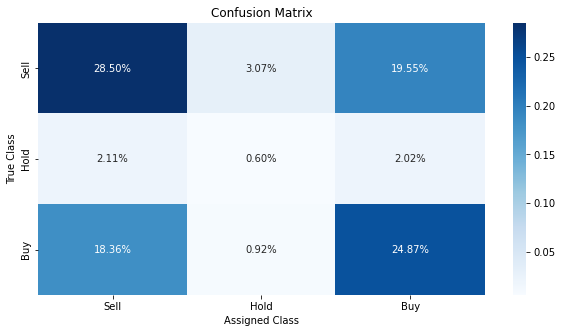

In [ ]:
############## Random Forest ##############

####################
### All Features ###
####################
forest = RandomForestClassifier(random_state = 42)
print(f"Parameters of the Random Forest: {forest.get_params().keys()}")

rfpipe = imbpipeline(steps=[["ros", ros], ["rf", forest]])

random_grid = {
    "rf__criterion": ["gini", "entropy"],
    "rf__max_features": ["auto", "sqrt", "log2"],
    "rf__max_depth": np.array([None, 5, 10, 20]),
    "rf__min_samples_leaf":np.array([1, 2, 5]),
    "rf__min_samples_split": np.array([2, 5, 10]),
    "rf__n_estimators": np.array([50, 100, 200, 500]),
    "rf__class_weight": [None, "balanced", "balanced_subsample"]
}

rs = RandomizedSearchCV(estimator = rfpipe, param_distributions = random_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1, n_iter = 100, random_state = 42, error_score = "raise")
rs = rs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(rs, X_test_cleaned, y_test_cleaned)
y_pred = rs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'rf__max_depth': None, 'rf__n_estimators': 250, 'ros': RandomOverSampler(random_state=42), 'scaler': None}
Mean CV score:  0.538284
Standard deviation of CV score:  0.003288
Test Score: 0.544336
              precision    recall  f1-score   support

           0       0.59      0.56      0.57      1114
           1       0.13      0.13      0.13       103
           2       0.54      0.57      0.56       962

    accuracy                           0.54      2179
   macro avg       0.42      0.42      0.42      2179
weighted avg       0.54      0.54      0.54      2179



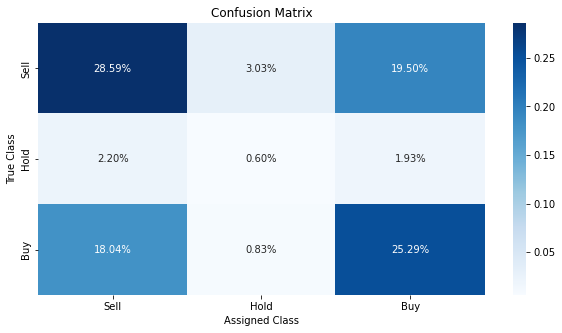

In [ ]:
############## Random Forest ##############

################################
### All Features: Finetuning ###
################################
forest = RandomForestClassifier(random_state = 42, class_weight = "balanced_subsample", criterion = "entropy", max_features = "sqrt", min_samples_split = 10, min_samples_leaf = 5)

rfpipe = imbpipeline(steps=[["scaler", scaler], ["ros", ros], ["rf", forest]])

param_grid = {
    "scaler": [scaler, mms, None],
    "ros": [ros, None],
    "rf__max_depth": [None, 5, 10, 15, 20],
    "rf__n_estimators": np.array([150, 200, 250])
}

gs = GridSearchCV(estimator = rfpipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'rf__n_estimators': 500, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 2, 'rf__max_features': 'log2', 'rf__max_depth': 20, 'rf__criterion': 'gini', 'rf__class_weight': 'balanced_subsample'}
Mean CV score:  0.546812
Standard deviation of CV score:  0.004268
Test Score: 0.492004
              precision    recall  f1-score   support

           0       0.54      0.69      0.61      1114
           1       0.00      0.00      0.00       103
           2       0.47      0.37      0.41       962

    accuracy                           0.52      2179
   macro avg       0.34      0.35      0.34      2179
weighted avg       0.48      0.52      0.49      2179



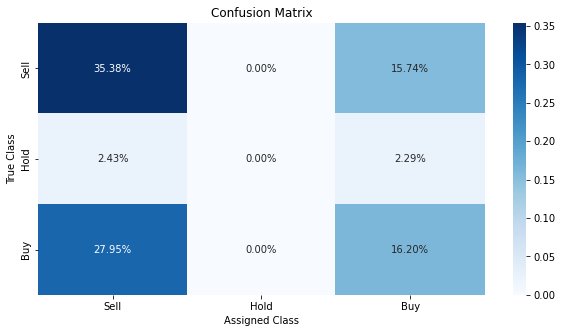

In [62]:
############## Random Forest ##############

########################################
### Random Forest Feature Selectionn ###
########################################
# instead of the pipeline implementation, we use the prepared data sets X_train_rf and X_test_rf
forest = RandomForestClassifier(random_state = 42)

rfpipe = imbpipeline(steps=[["ros", ros], ["rf", forest]])

random_grid = {
    "rf__criterion": ["gini", "entropy"],
    "rf__max_features": ["auto", "sqrt", "log2"],
    "rf__max_depth": np.array([None, 5, 10, 20]),
    "rf__min_samples_leaf":np.array([1, 2, 5]),
    "rf__min_samples_split": np.array([2, 5, 10]),
    "rf__n_estimators": np.array([ 100, 200, 500]),
    "rf__class_weight": [None, "balanced", "balanced_subsample"]
}

rs = RandomizedSearchCV(estimator = rfpipe, param_distributions = random_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1, n_iter = 100, random_state = 42, error_score = "raise")
rs = rs.fit(X_train_rf, y_train_cleaned)

get_results_cv(rs, X_test_rf, y_test_cleaned)
y_pred = rs.best_estimator_.predict(X_test_rf)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 5, 'rf__max_features': 'auto', 'rf__max_depth': None, 'rf__criterion': 'entropy', 'rf__class_weight': 'balanced_subsample'}
Mean CV score:  0.542880
Standard deviation of CV score:  0.007143
Test Score: 0.494023
              precision    recall  f1-score   support

           0       0.54      0.68      0.60      1114
           1       0.00      0.00      0.00       103
           2       0.48      0.39      0.43       962

    accuracy                           0.52      2179
   macro avg       0.34      0.35      0.34      2179
weighted avg       0.48      0.52      0.49      2179



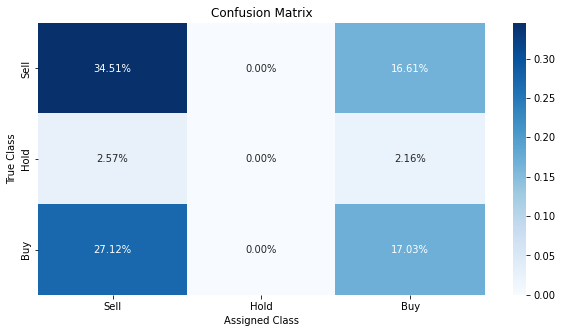

In [116]:
############## Random Forest ##############

########################################
### XGBoost Feature Selectionn ###
########################################
# instead of the pipeline implementation, we use the prepared data sets X_train_xgbc and X_test_xgbc
forest = RandomForestClassifier(random_state = 42)

rfpipe = imbpipeline(steps=[["ros", ros], ["rf", forest]])

random_grid = {
    "rf__criterion": ["gini", "entropy"],
    "rf__max_features": ["auto", "sqrt", "log2"],
    "rf__max_depth": np.array([None, 5, 10, 20]),
    "rf__min_samples_leaf":np.array([1, 2, 5]),
    "rf__min_samples_split": np.array([2, 5, 10]),
    "rf__n_estimators": np.array([ 100, 200]),
    "rf__class_weight": [None, "balanced", "balanced_subsample"]
}

rs = RandomizedSearchCV(estimator = rfpipe, param_distributions = random_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1, n_iter = 100 random_state = 42, error_score = "raise")
rs = rs.fit(X_train_xgbc, y_train_cleaned)

get_results_cv(rs, X_test_xgbc, y_test_cleaned)
y_pred = rs.best_estimator_.predict(X_test_xgbc)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'rf__n_estimators': 500, 'rf__max_depth': 20, 'rf__criterion': 'gini', 'kpca__n_components': 5, 'kpca__kernel': 'sigmoid', 'kpca__gamma': 0.01, 'kpca__coef0': 0.9}
Mean CV score:  0.492961
Standard deviation of CV score:  0.009349
Test Score: 0.494017
              precision    recall  f1-score   support

           0       0.54      0.49      0.52      1114
           1       0.10      0.13      0.11       103
           2       0.49      0.53      0.51       962

    accuracy                           0.49      2179
   macro avg       0.38      0.38      0.38      2179
weighted avg       0.50      0.49      0.49      2179



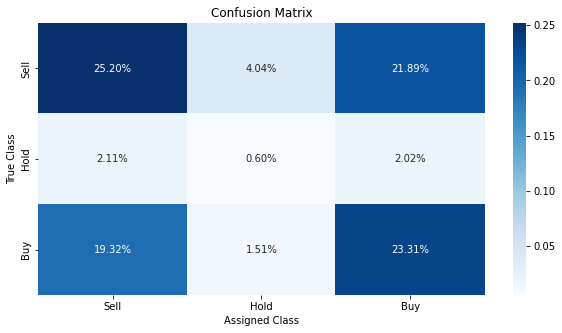

In [ ]:
############## Random Forest ##############

##############################################
### Kernel PCA: Broad Hyperparametertuning ###
##############################################
forest = RandomForestClassifier(random_state = 42, max_features = "sqrt")
kpca = KernelPCA(random_state = 42)
rfpipe = imbpipeline(steps=[["scaler", scaler],["kpca", kpca], ["ros", ros], ["rf", forest]])

random_grid = {
    "kpca__n_components": np.arange(4, 10, 1),
    "kpca__kernel": ["linear", "sigmoid"],
    "kpca__gamma": np.linspace(0.005, 0.01, 5),
    "kpca__coef0": np.linspace(0.8, 1.2, 5),
    "rf__criterion": ["gini", "entropy"],
    "rf__max_depth": np.array([None, 2, 5, 10, 20]),
    "rf__n_estimators": np.array([ 100, 200, 500]),
}

rs = RandomizedSearchCV(estimator = rfpipe, param_distributions = random_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1, n_iter = 100, random_state = 42, error_score = "raise")
rs = rs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(rs, X_test_cleaned, y_test_cleaned)
y_pred = rs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'rf__max_depth': 20, 'rf__n_estimators': 300, 'ros': None, 'scaler': StandardScaler()}
Mean CV score:  0.502137
Standard deviation of CV score:  0.003929
Test Score: 0.507401
              precision    recall  f1-score   support

           0       0.57      0.47      0.52      1114
           1       0.10      0.15      0.12       103
           2       0.50      0.58      0.54       962

    accuracy                           0.50      2179
   macro avg       0.39      0.40      0.39      2179
weighted avg       0.52      0.50      0.51      2179



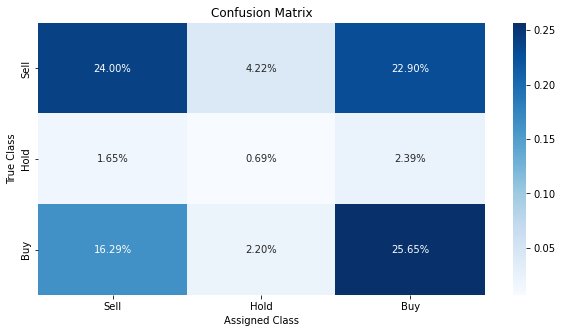

In [ ]:
############## Random Forest ##############

#############################################
### Kernel PCA: Hyperparameter Finetuning ###
#############################################
forest_ft = RandomForestClassifier(random_state = 42, class_weight = "balanced_subsample", criterion = "gini", 
                                   max_features = "sqrt", min_samples_leaf= 10, min_samples_split = 5)
kpca_rf_ft = KernelPCA(random_state = 42, kernel = "sigmoid", n_components = 5, gamma = 0.01, coef0 = 0.9)
rfpipe = imbpipeline(steps=[["scaler", scaler],["kpca", kpca_rf_ft], ["ros", ros], ["rf", forest_ft]])

param_grid = {
    "scaler": [scaler, mms, None],
    "ros": [ros, None],
    "rf__max_depth": np.array([15, 20, 25]),
    "rf__n_estimators": np.array([100, 300, 500]),
}

gs = GridSearchCV(estimator = rfpipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

The best performing random forest model is the one including all features without standardizing but with upsampling the data.

### Gradient Boosting

Parameters of XGBoost: dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity', 'tree_method', 'sampling_method'])
Best parameters: {'xgbc__gamma': 0, 'xgbc__learning_rate': 0.05, 'xgbc__max_depth': 6, 'xgbc__n_estimators': 1000}
Mean CV score:  0.555790
Standard deviation of CV score:  0.005240
Test Score: 0.546785
              precision    recall  f1-score   support

           0       0.59      0.58      0.59      1114
           1       0.11      0.11      0.11       103
           2       0.55      0.55      0.55       962

    accuracy                           0.55      2179
   macro avg       0.41      0.41      0.41      2179
weighted avg       0.55      0.55      0.55      2179



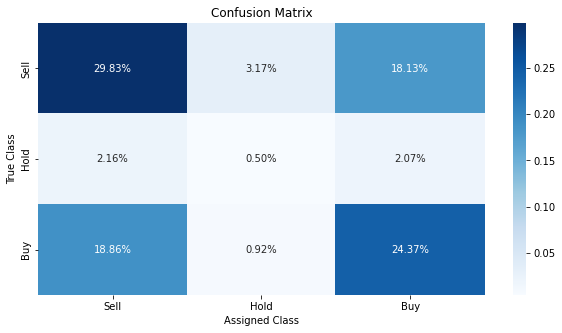

In [ ]:
############## Gradient Boosting ##############

####################
### All Features: Broad Hyperparametertuning ###
################################################
xgbc= xgb.XGBClassifier(tree_method = "gpu_hist", objective = "multi:softmax", sampling_method = "gradient_based", random_state = 42) # gpu_hist to run on GPU/ cuda to make XGBoost way faster
print(f"Parameters of XGBoost: {xgbc.get_params().keys()}")

xgbc_pipe = imbpipeline([
    ["scaler", scaler],
    ["ros", ros],
    ["xgbc", xgbc],
])


param_grid = {
    "xgbc__max_depth": [3, 4, 5, 6],
    "xgbc__n_estimators": [100, 200, 500],
    "xgbc__learning_rate": [0.001, 0.01, 0.05],
    "xgbc__gamma": [0, 0.25, 0.5, 0.75, 1],

}
gs = GridSearchCV(estimator = xgbc_pipe, param_grid = param_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'ros': None, 'scaler': None, 'xgbc__gamma': 0, 'xgbc__max_depth': 6, 'xgbc__n_estimators': 150}
Mean CV score:  0.573109
Standard deviation of CV score:  0.003837
Test Score: 0.577542
              precision    recall  f1-score   support

           0       0.60      0.71      0.65      1114
           1       1.00      0.01      0.02       103
           2       0.58      0.53      0.55       962

    accuracy                           0.59      2179
   macro avg       0.73      0.41      0.41      2179
weighted avg       0.61      0.59      0.58      2179



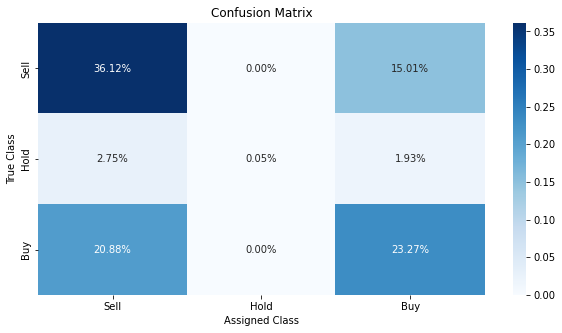

In [ ]:
############## Gradient Boosting ##############

################################
### All Features: Finetuning ###
################################
xgbc= xgb.XGBClassifier(tree_method = "gpu_hist", objective = "multi:softmax", 
                        sampling_method = "gradient_based", random_state = 42, learning_rate = 0.05)

xgbc_pipe = imbpipeline([
    ["scaler", scaler],
    ["ros", ros],
    ["xgbc", xgbc],
])

param_grid = {
    "scaler": [None, mms, scaler],
    "ros": [None, ros],
    "xgbc__n_estimators": [150, 200, 250],
    "xgbc__gamma": [0, 0.05, 0.1],
    "xgbc__max_depth": [6, 7, 8],
}
gs = GridSearchCV(estimator = xgbc_pipe, param_grid = param_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'xgbc__gamma': 0, 'xgbc__learning_rate': 0.05, 'xgbc__max_depth': 5, 'xgbc__n_estimators': 200}
Mean CV score:  0.568959
Standard deviation of CV score:  0.005228
Test Score: 0.469975
              precision    recall  f1-score   support

           0       0.54      0.53      0.53      1114
           1       0.04      0.10      0.06       103
           2       0.47      0.41      0.44       962

    accuracy                           0.46      2179
   macro avg       0.35      0.35      0.34      2179
weighted avg       0.48      0.46      0.47      2179



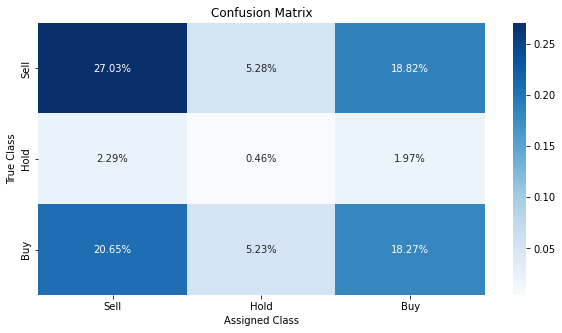

In [85]:
############## Gradient Boosting ##############

########################################
### Random Forest Feature Selectionn ###
########################################
# instead of the pipeline implementation, we use the prepared data sets X_train_rf and X_test_rf
xgbc= xgb.XGBClassifier(tree_method = "gpu_hist", objective = "multi:softmax", sampling_method = "gradient_based", random_state = 42) # gpu_hist to run on GPU/ cuda to make XGBoost way faster

xgbc_pipe = imbpipeline([
    ["xgbc", xgbc],
])


param_grid = {
    "xgbc__max_depth": [3, 4, 5, 6],
    "xgbc__n_estimators": [100, 200],
    "xgbc__learning_rate": [0.001, 0.01, 0.05],
    "xgbc__gamma": [0, 0.05, 0.1],
}

gs = GridSearchCV(estimator = xgbc_pipe, param_grid = param_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_rf, y_train_cleaned)

get_results_cv(gs, X_test_rf, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_rf)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'xgbc__gamma': 0, 'xgbc__learning_rate': 0.05, 'xgbc__max_depth': 5, 'xgbc__n_estimators': 200}
Mean CV score:  0.572895
Standard deviation of CV score:  0.004710
Test Score: 0.446025
              precision    recall  f1-score   support

           0       0.49      0.50      0.50      1114
           1       0.08      0.14      0.10       103
           2       0.44      0.41      0.43       962

    accuracy                           0.44      2179
   macro avg       0.34      0.35      0.34      2179
weighted avg       0.45      0.44      0.45      2179



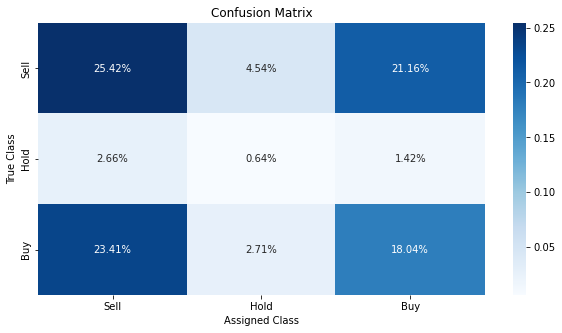

In [86]:
############## Random Forest ##############

########################################
### XGBoost Feature Selectionn ###
########################################
# instead of the pipeline implementation, we use the prepared data sets X_train_xgbc and X_test_xgbc
xgbc= xgb.XGBClassifier(tree_method = "gpu_hist", objective = "multi:softmax", sampling_method = "gradient_based", random_state = 42) # gpu_hist to make XGBoost way faster

xgbc_pipe = imbpipeline([
    ["xgbc", xgbc],
])


param_grid = {
    "xgbc__max_depth": [3, 4, 5, 6],
    "xgbc__n_estimators": [100, 200],
    "xgbc__learning_rate": [0.001, 0.01, 0.05],
    "xgbc__gamma": [0, 0.05, 0.1],
}

gs = GridSearchCV(estimator = xgbc_pipe, param_grid = param_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_xgbc, y_train_cleaned)

get_results_cv(gs, X_test_xgbc, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_xgbc)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'xgbc__n_estimators': 150, 'xgbc__max_depth': 6, 'xgbc__learning_rate': 0.05, 'xgbc__gamma': 0, 'kpca__n_components': 8, 'kpca__kernel': 'linear', 'kpca__gamma': 0.005}
Mean CV score:  0.511336
Standard deviation of CV score:  0.005173
Test Score: 0.506547
              precision    recall  f1-score   support

           0       0.54      0.68      0.61      1114
           1       0.00      0.00      0.00       103
           2       0.50      0.40      0.45       962

    accuracy                           0.53      2179
   macro avg       0.35      0.36      0.35      2179
weighted avg       0.50      0.53      0.51      2179



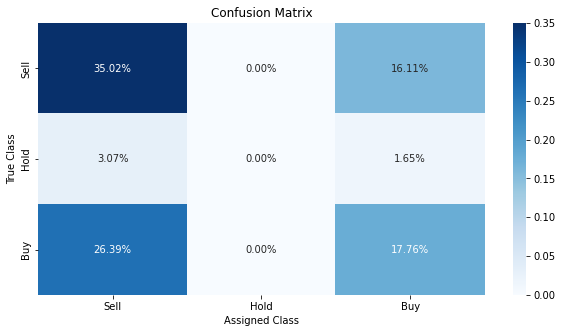

In [55]:
############## Gradient Boosting ##############

##############################################
### Kernel PCA: Broad Hyperparametertuning ###
##############################################
kpca = KernelPCA(random_state = 42)
xgbc= xgb.XGBClassifier(tree_method = "gpu_hist", objective = "multi:softmax", max_depth = 5,
                        sampling_method = "gradient_based", random_state = 42)

xgbc_pipe = imbpipeline([
    ["kpca", kpca],
    ["xgbc", xgbc],
])
random_grid = {
    "kpca__n_components": np.arange(4, 10, 1),
    "kpca__kernel": ["linear", "sigmoid"],
    "kpca__gamma": np.linspace(0.005, 0.01, 10),
    "xgbc__max_depth": [3, 4, 5, 6],
    "xgbc__n_estimators": [100, 150, 200],
    "xgbc__gamma": [0, 0.1, 0.2],
    "xgbc__learning_rate": [0.001, 0.01, 0.05],
}

rs = RandomizedSearchCV(estimator = xgbc_pipe, param_distributions = random_grid, scoring = "f1_weighted",
                  cv = kFold, n_iter = 50, random_state = 42, error_score = "raise")
rs = rs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(rs, X_test_cleaned, y_test_cleaned)
y_pred = rs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'kpca__kernel': 'sigmoid', 'ros': None, 'scaler': StandardScaler()}
Mean CV score:  0.520747
Standard deviation of CV score:  0.007945
Test Score: 0.525520
              precision    recall  f1-score   support

           0       0.56      0.66      0.61      1114
           1       0.00      0.00      0.00       103
           2       0.51      0.46      0.49       962

    accuracy                           0.54      2179
   macro avg       0.36      0.37      0.36      2179
weighted avg       0.51      0.54      0.53      2179



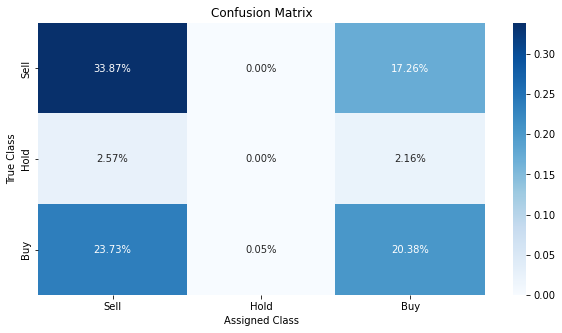

In [63]:
############## Gradient Boosting ##############

#############################################
### Kernel PCA: Hyperparameter Finetuning ###
#############################################
kpca = KernelPCA(random_state = 42, n_components = 8, gamma = 0.005)
xgbc= xgb.XGBClassifier(tree_method = "gpu_hist", objective = "multi:softmax", max_depth = 6,
                        sampling_method = "gradient_based", random_state = 42, gamma = 0, learning_rate = 0.05, n_estimators = 150)

xgbc_pipe = imbpipeline([
    ["scaler", scaler],
    ["ros", ros],
    ["kpca", kpca],
    ["xgbc", xgbc],
])
param_grid = {
    "scaler": [None, mms, scaler],
    "ros": [None, ros],
    "kpca__kernel": ["linear", "sigmoid"],
}
gs = GridSearchCV(estimator = xgbc_pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Interestingly, the XGBoost Classifier performed best when we neither upsampled nor scaled the data.

### Support Vector Machine

At first, the SVM code took very long to execute even for a very small parameter grid. We later on realised that the reason for this is that we had the option None for our scaler which apparently led to some convergence issues. To further speed up the code, we also reduced the grid size.

Parameters of the Support Vector Machine: dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])
Best parameters: {'SVM__C': 1, 'SVM__gamma': 'scale', 'SVM__kernel': 'sigmoid', 'ros': None, 'scaler': MinMaxScaler()}
Mean CV score:  0.473599
Standard deviation of CV score:  0.006300
Test Score: 0.469559
              precision    recall  f1-score   support

           0       0.53      0.77      0.63      1114
           1       0.00      0.00      0.00       103
           2       0.47      0.26      0.34       962

    accuracy                           0.51      2179
   macro avg       0.33      0.35      0.32      2179
weighted avg       0.48      0.51      0.47      2179



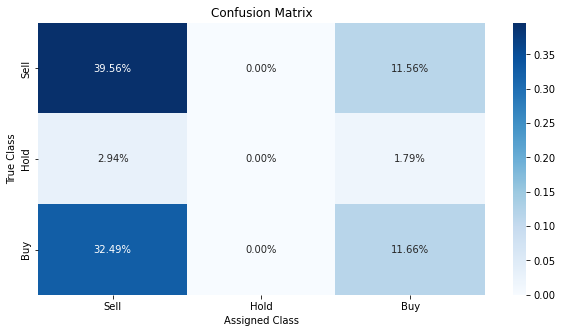

In [72]:
############## Support Vector Machine ##############


####################
### All Features ###
####################
svm = SVC(random_state = 42, max_iter = 1000, shrinking = True)
print(f"Parameters of the Support Vector Machine: {svm.get_params().keys()}")

svm_pipe = imbpipeline(steps=[["scaler", scaler], ["ros", ros], ["SVM", svm]])
param_grid = {
    'ros': [ros, None], 
    'scaler': [scaler, mms],
    "SVM__kernel": ["linear", "sigmoid"],
    "SVM__C": [1, 10],
    "SVM__gamma": ["auto", "scale"]
}
gs = GridSearchCV(estimator = svm_pipe, param_grid = param_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'SVM__C': 10, 'SVM__gamma': 'auto', 'SVM__kernel': 'sigmoid', 'ros': None, 'scaler': StandardScaler()}
Mean CV score:  0.320453
Standard deviation of CV score:  0.023699
Test Score: 0.415749
              precision    recall  f1-score   support

           0       0.50      0.26      0.35      1114
           1       0.05      0.04      0.04       103
           2       0.44      0.69      0.54       962

    accuracy                           0.44      2179
   macro avg       0.33      0.33      0.31      2179
weighted avg       0.45      0.44      0.42      2179



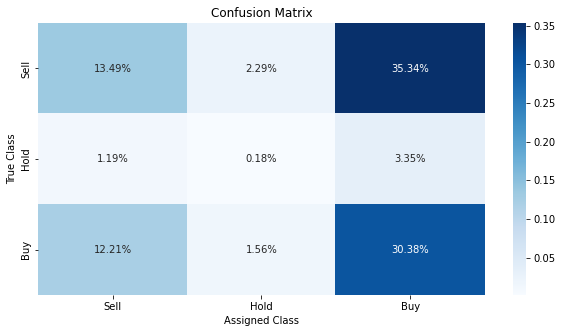

In [87]:
############## Support Vector Machine ##############

#######################################
### Random Forest Feature Selection ###
#######################################
svm = SVC(random_state = 42, max_iter = 1000)
pipe = imbpipeline(steps=[["scaler", scaler],["ros", ros], ["SVM", svm]])

param_grid= {
    "scaler": [scaler, mms],
    "ros": [ros, None],
    "SVM__kernel": ["linear", "sigmoid"],
    "SVM__C": [1, 10],
    "SVM__gamma": ["auto", "scale"]
}
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_rf, y_train_cleaned)

get_results_cv(gs, X_test_rf, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_rf)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'SVM__C': 1, 'SVM__gamma': 'scale', 'SVM__kernel': 'sigmoid', 'ros': None, 'scaler': MinMaxScaler()}
Mean CV score:  0.377344
Standard deviation of CV score:  0.055320
Test Score: 0.272727
              precision    recall  f1-score   support

           0       0.38      0.00      0.01      1114
           1       0.00      0.00      0.00       103
           2       0.44      1.00      0.61       962

    accuracy                           0.44      2179
   macro avg       0.27      0.33      0.21      2179
weighted avg       0.39      0.44      0.27      2179



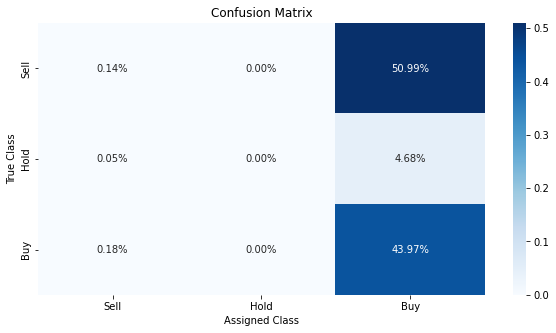

In [89]:
############## Support Vector Machine ##############

#################################
### XGBoost Feature Selection ###
#################################
svm = SVC(random_state = 42, max_iter = 1000)
pipe = imbpipeline(steps=[["scaler", scaler],["ros", ros], ["SVM", svm]])

param_grid= {
    "scaler": [scaler, mms],
    "ros": [ros, None],
    "SVM__kernel": ["linear", "sigmoid"],
    "SVM__C": [1, 10],
    "SVM__gamma": ["auto", "scale"]
}
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_xgbc, y_train_cleaned)

get_results_cv(gs, X_test_xgbc, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_xgbc)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'SVM__gamma': 'auto', 'pca__n_components': 4, 'ros': None, 'scaler': MinMaxScaler()}
Mean CV score:  0.466754
Standard deviation of CV score:  0.009665
Test Score: 0.458597
              precision    recall  f1-score   support

           0       0.52      0.37      0.43      1114
           1       0.00      0.00      0.00       103
           2       0.45      0.65      0.54       962

    accuracy                           0.48      2179
   macro avg       0.32      0.34      0.32      2179
weighted avg       0.47      0.48      0.46      2179



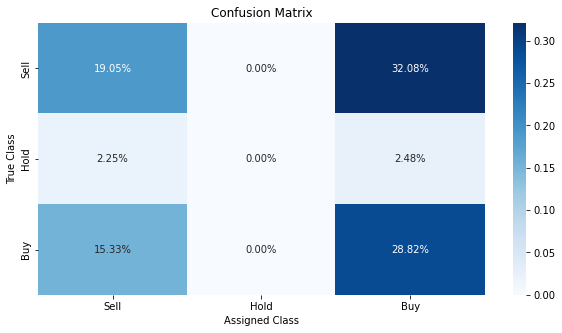

In [78]:
############## Support Vector Machine ##############

###############################
### PCA Dimension Reduction ###
###############################
svm = SVC(random_state = 42, max_iter = 1000, shrinking = True, kernel = "sigmoid", C = 1)
pca = PCA()

svm_pipe = imbpipeline(steps=[["scaler", scaler], ["pca", pca], ["ros", ros], ["SVM", svm]])
param_grid = {
    'ros': [ros, None], 
    'scaler': [scaler, mms],
    "SVM__gamma": ["auto", "scale"],
    "pca__n_components": np.arange(4, 10, 1)
}
gs = GridSearchCV(estimator = svm_pipe, param_grid = param_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

### Neural Network

We decided to use PyTorch instead of Keras for our Neural Networks because we wanted that everyone in our group can get a grasp of Neural Networks and their fitting process. Instead of treating a Neural Network's fitting process as some sort of a black box (as it is the case in Keras) we tried to implement a step-by-step approach for forward- and backpropagation in PyTorch that should provide some more insight into how Neural Networks work. We start by creating a relatively simple feedforward Neural Network with one hidden layer.

In [21]:
############## Neural Network ##############
## Standardise cleaned train& test set
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train_cleaned)
X_test_std = sc.fit_transform(X_test_cleaned)

In [22]:
############## Neural Network ##############

class FinMod1(nn.Module):
  """Feedforward neural network with 1 hidden layer"""
  def __init__(self, input_size, hidden_size, output_size, dropout_rate, activ_func):
    super().__init__()
    # hidden layer (layer between input and output layer)
    self.hidden = nn.Linear(input_size, hidden_size)
    # output layer
    self.output = nn.Linear(hidden_size, 3)
    # Dropout Layer to prevent high correlation (co-adaptation) between layers 
    # without dropout overfitting is likely due to the many parameters/ weights)
    # dropout samples from Bernoulli distribution with p=dropout_rate and randomly sets some elements of the layer output to zero
    self.drop = nn.Dropout(p = dropout_rate)
    # Apply activation function to introduce non-linearity e.g. relu: max(0,x)
    # Without activation function it would just be a linear combination of the input
    self.activ_func = activ_func
  def forward(self, x):
    # Get intermediate outputs using hidden layer
    out = self.hidden(x)
    # Apply activation function to output of hidden layer
    out = self.activ_func(out)
    # randomly zero some elements
    out = self.drop(out)
    # Get predictions using output layer
    out = self.output(out)
    # softmax/ normalized exponential function to get results that lie in (0, 1)
    # returns tensor that can be interpreted as a 3-tuple of predicted probabilities that a observation belongs to the corresponding class
    out = F.softmax(out, dim = 1)
    return out

Next we created a more complex model with two hidden layers to compare it to:

In [23]:
############## Neural Network ##############

## Create the model
class FinMod2(nn.Module):
  """Feedforward neural network with 2 hidden layers"""
  def __init__(self, input_size, hidden1_size, hidden2_size, output_size, dropout_rate1,
               dropout_rate2, activ_func1, activ_func2):
    super().__init__()
    # 1st hidden layer
    self.hidden1 = nn.Linear(input_size, hidden1_size)
    # 2nd hidden layer
    self.hidden2 = nn.Linear(hidden1_size, hidden2_size)
    # output layer
    self.output = nn.Linear(hidden2_size, output_size)
    self.drop1 = nn.Dropout(p = dropout_rate1)
    self.drop2 = nn.Dropout(p = dropout_rate2)
    self.activ_func1 = activ_func1
    self.activ_func2 = activ_func2
  def forward(self, x):
    # Get intermediate outputs using hidden layer
    out = self.hidden1(x)
    # Non linear activation function
    out = self.activ_func1(out)
    # randomly zero some elements
    out = self.drop1(out)
    # pass through 2nd hidden layer
    out = self.hidden2(out)
    # Non-linear activation function
    out = self.activ_func2(out)
    # zero some elements
    out = self.drop2(out)
    # Get predictions using output layer
    out = self.output(out)
    # softmax to get predicted probabilities
    out = F.softmax(out, dim = 1)
    return out

For good measure we also created a more complex Neural Network with 5 hidden layers to compare it to. We will later on see that more layers do not necessarily yield a higher score.

In [24]:
############## Neural Network ##############

class FinMod3(nn.Module):
  """
  Feed Forward Neural Network with 5 hidden layers and relu as activation function
  """
  def __init__(self, input_size, output_size):
    super().__init__()
    # 1st hidden layer
    self.hidden1 = nn.Linear(input_size, 100)
    # 2nd hidden layer
    self.hidden2 = nn.Linear(100, 80)
    # 3rd hidden layer
    self.hidden3 = nn.Linear(80, 60)
    # 4th hidden layer
    self.hidden4 = nn.Linear(60, 40)
    # 5th hidden layer
    self.hidden5 = nn.Linear(40, 20)
    # output layer
    self.output = nn.Linear(20, output_size)
    # Dropout
    self.drop = nn.Dropout(p = 0.2)
  def forward(self, x):
    # Apply activation function relu& dropout to output of first, second, ... hidden layer
    out = self.drop(F.relu(self.hidden1(x)))
    out = self.drop(F.relu(self.hidden2(out)))
    out = self.drop(F.relu(self.hidden3(out)))
    out = self.drop(F.relu(self.hidden4(out)))
    out = self.drop(F.relu(self.hidden5(out)))

    # Get predictions using output layer
    out = self.output(out)
    # softmax to get predicted probabilities
    out = F.softmax(out, dim = 1)
    return out

Lastly, we also created a Feedforward Neural Network with 10 hidden layers.

In [25]:
############## Neural Network ##############

class FinMod4(nn.Module):
  """
  Feed Forward Neural Network with 10 hidden layers and relu as activation function
  """
  def __init__(self, input_size, output_size):
    super().__init__()
    # 1st hidden layer
    self.hidden1 = nn.Linear(input_size, 100)
    # 2nd hidden layer
    self.hidden2 = nn.Linear(100, 100)
    # 3rd hidden layer
    self.hidden3 = nn.Linear(100, 80)
    # 4th hidden layer
    self.hidden4 = nn.Linear(80, 80)
    # 5th hidden layer
    self.hidden5 = nn.Linear(80, 60)
    # 6th hidden layer
    self.hidden6 = nn.Linear(60, 60)
    # 7th hidden layer
    self.hidden7 = nn.Linear(60, 60)
    # 8th hidden layer
    self.hidden8 = nn.Linear(60, 40)
    # 9th hidden layer
    self.hidden9 = nn.Linear(40, 40)
    # 10th hidden layer
    self.hidden10 = nn.Linear(40, 20)
    # output layer
    self.output = nn.Linear(20, output_size)
    # Dropout
    self.drop = nn.Dropout(p = 0.2)
  def forward(self, x):
    # Apply activation function relu& dropout to output of first, second, ... hidden layer
    out = self.drop(F.relu(self.hidden1(x)))
    out = self.drop(F.relu(self.hidden2(out)))
    out = self.drop(F.relu(self.hidden3(out)))
    out = self.drop(F.relu(self.hidden4(out)))
    out = self.drop(F.relu(self.hidden5(out)))
    out = self.drop(F.relu(self.hidden6(out)))
    out = self.drop(F.relu(self.hidden7(out)))
    out = self.drop(F.relu(self.hidden8(out)))
    out = self.drop(F.relu(self.hidden9(out)))
    out = self.drop(F.relu(self.hidden10(out)))
    # Get predictions using output layer
    out = self.output(out)
    # softmax to get predicted probabilities
    out = F.softmax(out, dim = 1)
    return out

Since matrix multiplications are faster on GPU we decided to load the data and the models onto the GPU (if available).The code necessary for this is from the youtube [PyTorch for Deep Learning](https://youtu.be/GIsg-ZUy0MY?t=14364) course from freeCodeAcademy.org.

In [26]:
############## Functions for Moving Data and Model to GPU ##############

# Check whether GPU is available
print(torch.cuda.is_available())

# Function to check whether GPU is available or not and select GPU if it is available
def get_device():
  """If possible choose cuda/GPU, otherwise choose CPU"""
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

device = get_device()
print(device)

# Function to move our data/ model to GPU
def to_device(data, device):
  """Move tensors to GPU"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

# Function that allows to transfer data batchwise to GPU
class DeviceDataLoader():
    """Dataloader to move data to device"""
    def __init__(self, dat_loader, device):
        self.dat_loader = dat_loader
        self.device = device
        
    def __iter__(self):
        """Move batches to device"""
        for batch in self.dat_loader: 
            # use yield to move batches to device one by one and automatically remove from device when it is no longer used
            # this way not all data is moved to the device at once
            yield to_device(batch, self.device) 

    def __len__(self):
        """Return number of batches"""
        return len(self.dat_loader)

True
cuda


To find hyperparameters that yield a good weighted $F_1$-Score we want to define a function that conducts k-fold cross-validation allowing us to evaluate the model for different choices of the hyperparameters. For this we need a way to reset the weights in the beginning of every fold in order to avoid leakage (use of information that should not be available when starting a new fold). The code for this function to reset the weights is from [github](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md#:~:text=self.layers(x)-,Before,-the%20class%2C%20we). There also exists a package called ["skorch"](https://skorch.readthedocs.io/en/stable/user/quickstart.html) that allows for a pipeline and GridSearchCV/ RandomizedSearchCV implementation of PyTorch Neural Networks in the familiar sklearn environment (see appendix for a skorch implementation of our models). We used skorch to get a broad idea of the magnitude of our parameters for our first two models and then used our own k-fold cross-validation function to finetune the model. In particular, we used skorch to see that the neural network yielded the best results when standardizing the data but **not** upsampling it.

In [27]:
############## Function for Resetting the Weights of the Model ##############

def reset_weights(model):
  """
  Inputs required: model
  Reset the weights of the model to avoid leakage if code is executed several times
  """
  for layer in model.children():
   if hasattr(layer, "reset_parameters"):
    print(f"Reset trainable parameters of layer = {layer}")
    layer.reset_parameters()

In [28]:
############## Function for Training and Validating the Model ##############

def train_val_nn(model, n_epochs, train_loader, val_loader, optimizer):
  """
  Inputs required: model, number of epochs, train dataloader, validation dataloader, optimizer
  Trains model using batches from train_loader with the help of forward and backward propagation. Model is then validated using batches from 
  the val_loader. This is done n_epochs many times, where 1 epoch is one batchwise iteration through the whole train & validation set. After each
  epoch the epoch number, average training loss of the epoch and the average validation loss of the epoch is returned.
  """
  torch.manual_seed(42) # set seed, note: does not work perfectly
  # reset weights after every fold to avoid leakage
  reset_weights(model)
  # one epoch is one iteration (forwards and backwards) through all the train and validation examples
  for epoch in range(0, n_epochs):
    ###### Training the model
    # model.train() to tell model that we are training so that dropout layers get used
    model.train()
    train_loss = 0
    # for loop to iterate over whole dataloader batchwise
    for X_train_batch, y_train_batch in train_loader:
      # clear existing gradients
      optimizer.zero_grad()
      # Forward Propagation: Input data to get predicted probability that observation belongs to class 0/1/2
      output = model(X_train_batch)
      # Batch loss: compare predicted class with true class; cross entropy is a loss function for multiclass classification
      loss = F.cross_entropy(output, y_train_batch)
      # Calculate the derivative/ gradient of the loss function
      loss.backward()
      # Backpropagation: Use (stochastic) gradient descent to find direction/ parameters that decrease loss the fastest
      # Use this information to update the model parameters
      optimizer.step()
      # sum up train losses of all batches for this epoch
      train_loss += loss.item() # .item() to return a standard python number instead of tensor
    ###### Validating the model
    # model.eval() to tell model that we are testing so that dropout layers do not get used
    model.eval()
    val_loss = 0
    f1_w_val = 0
    # create empty list to store all predicted & true classes
    y_pred = []
    y_true = []
    # we do not want gradient descent for validation set
    with torch.no_grad():
      for X_val_batch, y_val_batch in val_loader:
        output = model(X_val_batch)
        loss = F.cross_entropy(output, y_val_batch)
        # sum up val losses of all batches for this epoch
        val_loss += loss.item()
        # predicted class is the index of the output for which the predicted probability is the highest
        pred_class = torch.argmax(output.data, 1)
        # extend lists by adding predicted class/ true class
        y_pred.extend(pred_class.data.cpu().tolist())
        y_true.extend(y_val_batch.data.cpu().tolist())
    # Calculate average train/ validation loss for epoch
    train_loss /= len(train_loader) # approximate Average Training Loss
    val_loss /= len(val_loader)     # approximate Average validation Loss
    train_val_nn.f1_w_val = metrics.f1_score(y_true, y_pred, average  ="weighted") # validation weighted f1-score
    print(f"Epoch: {epoch+1}/{n_epochs}  |   Training loss: {train_loss: .6f}  |  Validation loss: {val_loss: .6f} | Validation weighted F1-Score: {train_val_nn.f1_w_val: .6f}  ")
  # Calculate weighted F1-Score of validation set for last epoch:
  print()
  print(f"                 Validation weighted F1-Score of last epoch: {train_val_nn.f1_w_val: .6f}")

In [29]:
############## Function for Testing the Model ##############

def test_nn(model, test_loader):
  """
  Inputs required: model, test data loader
  Predicts classes of the test set using the model (model should already be trained using cross-validation). Returns the average test loss over all batches
  and a heatmap of the confusion matrix as well as a metrics report.
  """
  torch.manual_seed(42)
  # model.eval() to tell model that we are testing so that dropout layers do not get used
  model.eval()
  test_loss = 0
  # create empty list to store all predicted & true classes
  y_pred = []
  y_true = []
  # turn off gradients for testing; do not want to apply gradient descent onto our validation set!
  with torch.no_grad():
      for X_test_batch, y_test_batch in test_loader:
          output = model(X_test_batch)
          # test batch loss
          loss = F.cross_entropy(output, y_test_batch) 
          # sum up test losses of all batches
          # use .item() to convert tensor to convert to standard python number
          test_loss += loss.item()
          # argmax to find the index of the largest value of the tensor
          pred_class = torch.argmax(output.data, 1)
          # extend lists by adding predicted class/ true class
          y_pred.extend(pred_class.data.cpu().tolist())
          y_true.extend(y_test_batch.data.cpu().tolist())

  test_loss /= len(test_loader) # approximate test loss
  f1_w_test = metrics.f1_score(y_true, y_pred, average  ="weighted") # test weighted f1-score
  print()
  print(f"           Test loss: {test_loss: .6f}  |  Test weighted F1-Score: {f1_w_test: .6f}")
  print()   
  # Return confusion matrix heatmap and metrics report
  final_report(y_true, y_pred)

In [30]:
############## Function for K-Fold Cross-Validation and Testing the Model ##############

def evaluate_model(model, kFold, X_train_std, y_train_cleaned, X_test_std, y_test_cleaned, batch_size, n_epochs, optimizer):
  """ 
  Inputs required: model, kFold, standardized X train set, cleaned y train set, standardized X test set, cleaned y test set, batch size, number of epochs, optimizer
  Applies k-fold cross-validation to the model and uses the model with the highest weighted F1-score on the validation set out of all folds to test. Weights get reset
  after every fold. Returns results of each fold, a metrics report for the test set and a heatmap of the confusion matrix for the test set.
  """
  torch.manual_seed(42) # set seed
  f1_w = []
  # Convert to Tensor Datasets
  X_train_ten = torch.from_numpy(X_train_std).type(torch.Tensor)
  y_train_ten = Variable(torch.Tensor(y_train_cleaned).long())
  train_ds = TensorDataset(X_train_ten, y_train_ten)

  for fold, (train, val) in enumerate(kFold.split(X_train_std, y_train_cleaned)): # enumerate to simultaneously save fold nr and split into train and validation set
    print()
    print(f"------------------------------------- FOLD NUMBER: {fold+1} -------------------------------------")
    print()

    # Split into train and validation set
    train_subsampler = SubsetRandomSampler(train)
    val_subsampler = SubsetRandomSampler(val)

    # Define DataLoaders for this fold to allow for batchwise iterations through the dataset
    train_loader = DataLoader(train_ds, batch_size, sampler = train_subsampler)
    val_loader = DataLoader(train_ds, batch_size, sampler = val_subsampler)

    # Move DataLoaders to device to move batch from train/ val data loader to device if this batch is needed
    train_loader = DeviceDataLoader(train_loader, device)
    val_loader = DeviceDataLoader(val_loader, device)

    # For each fold train model using train set and validate using validation set; weights get reset at the beginning
    train_val_nn(model, n_epochs, train_loader, val_loader, optimizer)

    # Get average weighted F1-Score of last epoch of fold:
    f1_w.append(train_val_nn.f1_w_val)
    
    # Save the model
    save_path = f"fold-{fold}.pt"
    torch.save(model.state_dict(), save_path)

  reset_weights(model)
  # load model with best weighted f1 score on validation set
  best_fold = np.argmax(f1_w) # get index of highest validation weighted f1-score
  print()
  print(f"                             Best Fold: {best_fold+1}")
  load_path = f"fold-{best_fold}.pt"
  model.load_state_dict(torch.load(load_path))

  # Convert test set to Tensor Dataset
  X_test_ten = torch.from_numpy(X_test_std).type(torch.Tensor)
  y_test_ten = Variable(torch.Tensor(y_test_cleaned).long())
  test_ds = TensorDataset(X_test_ten, y_test_ten)

  # Define Test DataLoader to allow for batchwise iterations through test dataset
  test_loader = DataLoader(test_ds, batch_size, shuffle = True)
  # Move test data loader to device to move batch from test data loader to device if this batch is needed
  test_loader = DeviceDataLoader(test_loader, device)
  # Test the model
  test_nn(model, test_loader)



------------------------------------- FOLD NUMBER: 1 -------------------------------------

Reset trainable parameters of layer = Linear(in_features=145, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=3, bias=True)
Epoch: 1/100  |   Training loss:  1.071466  |  Validation loss:  1.051848 | Validation weighted F1-Score:  0.363827  
Epoch: 2/100  |   Training loss:  1.038495  |  Validation loss:  1.024101 | Validation weighted F1-Score:  0.387128  
Epoch: 3/100  |   Training loss:  1.014697  |  Validation loss:  1.004422 | Validation weighted F1-Score:  0.411755  
Epoch: 4/100  |   Training loss:  0.999041  |  Validation loss:  0.992323 | Validation weighted F1-Score:  0.419110  
Epoch: 5/100  |   Training loss:  0.989520  |  Validation loss:  0.984471 | Validation weighted F1-Score:  0.440460  
Epoch: 6/100  |   Training loss:  0.982801  |  Validation loss:  0.978976 | Validation weighted F1-Score:  0.448723  
Epoch: 7/100  |   T

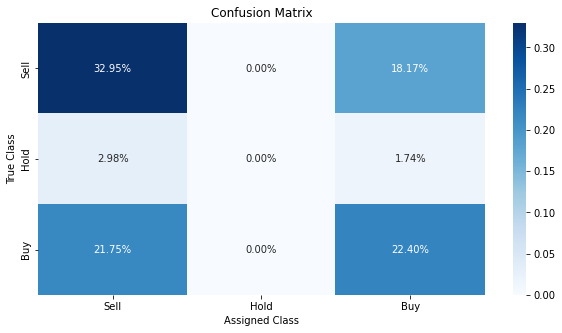

In [100]:
############## Feedforward NN with One Hidden Layer ##############

####################
### All Features ###
####################
n_epochs = 100 # how many times we iterate through train-& validation set (forward- and backpropagation)
input_size = 145 # nr of features
num_classes = 3
dropout_rate = 0.2
hidden = 100
# Initialize model
model1 = FinMod1(input_size, hidden, num_classes, dropout_rate, F.leaky_relu)
# Move model ot device
to_device(model1, device)
## Initialize optimizer:
# optimizer uses some variant of stochastic gradient descent to update the weights
# Learning rate is used to determine the step-size
optimizer1 = torch.optim.Adam(model1.parameters(), lr = 1e-4)  # initialize optimizer
batch_size = 128 # number of training examples in one forward and backward pass
evaluate_model(model1, kFold, X_train_std, y_train_cleaned, X_test_std, y_test_cleaned, batch_size, n_epochs, optimizer1)


------------------------------------- FOLD NUMBER: 1 -------------------------------------

Reset trainable parameters of layer = Linear(in_features=145, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=3, bias=True)
Epoch: 1/100  |   Training loss:  1.063295  |  Validation loss:  1.029141 | Validation weighted F1-Score:  0.349688  
Epoch: 2/100  |   Training loss:  1.007386  |  Validation loss:  0.989326 | Validation weighted F1-Score:  0.358387  
Epoch: 3/100  |   Training loss:  0.984069  |  Validation loss:  0.976872 | Validation weighted F1-Score:  0.413968  
Epoch: 4/100  |   Training loss:  0.975749  |  Validation loss:  0.971291 | Validation weighted F1-Score:  0.458346  
Epoch: 5/100  |   Training loss:  0.970808  |  Validation loss:  0.968042 | Validation weighted F1-Score:  0.507683  
Epoch: 6/100  |   Training loss:  0.967616  | 

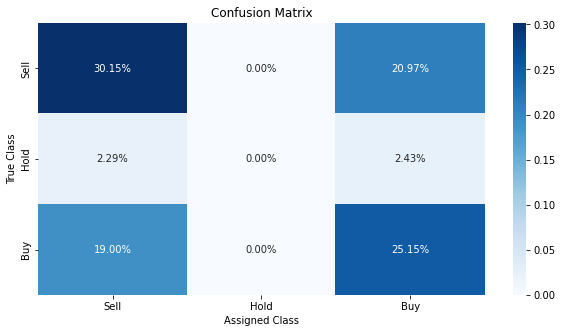

In [103]:
############## Feedforward NN with Two Hidden Layers ##############

####################
### All Features ###
####################
input_size = 145
num_classes = 3
batch_size = 128
n_epochs =  100
hidden1 = 100
hidden2 = 100
dropout_rate = 0.2
dropout_rate2 = 0.15
model2 = FinMod2(input_size, hidden1, hidden2, num_classes, dropout_rate, dropout_rate2, F.leaky_relu, torch.tanh)
to_device(model2, device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 1e-4) 

evaluate_model(model2, kFold, X_train_std, y_train_cleaned, X_test_std, y_test_cleaned, batch_size, n_epochs, optimizer2)


------------------------------------- FOLD NUMBER: 1 -------------------------------------

Reset trainable parameters of layer = Linear(in_features=145, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=80, bias=True)
Reset trainable parameters of layer = Linear(in_features=80, out_features=60, bias=True)
Reset trainable parameters of layer = Linear(in_features=60, out_features=40, bias=True)
Reset trainable parameters of layer = Linear(in_features=40, out_features=20, bias=True)
Reset trainable parameters of layer = Linear(in_features=20, out_features=3, bias=True)
Epoch: 1/100  |   Training loss:  1.105306  |  Validation loss:  1.102386 | Validation weighted F1-Score:  0.066196  
Epoch: 2/100  |   Training loss:  1.096991  |  Validation loss:  1.088694 | Validation weighted F1-Score:  0.345129  
Epoch: 3/100  |   Training loss:  1.066707  |  Validation loss:  1.033576 | Validation weighted F1-Score:  0.345129  
Epoch: 4/100  |  

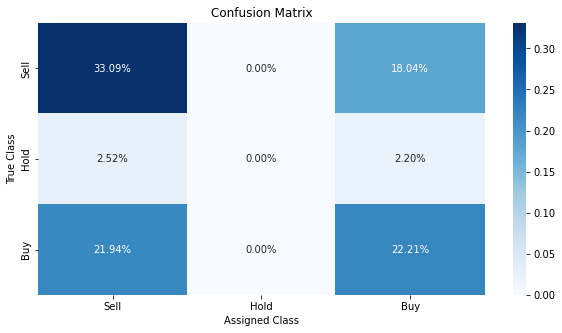

In [104]:
############## Feedforward NN with Five Hidden Layers ##############

####################
### All Features ###
####################
input_size = 145
num_classes = 3
batch_size = 128
n_epochs =  100 
model3 = FinMod3(input_size, num_classes)
to_device(model3, device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr = 5e-5) 

evaluate_model(model3, kFold, X_train_std, y_train_cleaned, X_test_std, y_test_cleaned, batch_size, n_epochs, optimizer3)


------------------------------------- FOLD NUMBER: 1 -------------------------------------

Reset trainable parameters of layer = Linear(in_features=145, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=80, bias=True)
Reset trainable parameters of layer = Linear(in_features=80, out_features=80, bias=True)
Reset trainable parameters of layer = Linear(in_features=80, out_features=60, bias=True)
Reset trainable parameters of layer = Linear(in_features=60, out_features=60, bias=True)
Reset trainable parameters of layer = Linear(in_features=60, out_features=60, bias=True)
Reset trainable parameters of layer = Linear(in_features=60, out_features=40, bias=True)
Reset trainable parameters of layer = Linear(in_features=40, out_features=40, bias=True)
Reset trainable parameters of layer = Linear(in_features=40, out_features=20, bias=True)
Reset traina

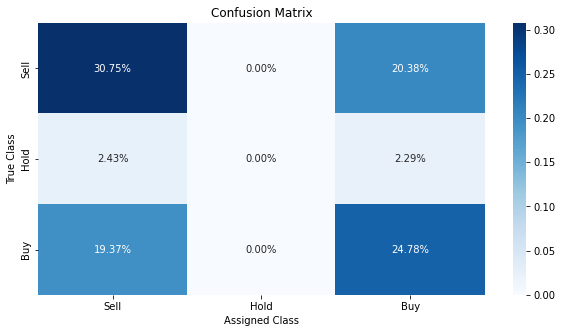

In [105]:
############## Feedforward NN with Ten Hidden Layers ##############

####################
### All Features ###
####################
input_size = 145
num_classes = 3
batch_size = 128
n_epochs =  100
model4 = FinMod4(input_size, num_classes)
to_device(model4, device)
optimizer4 =  torch.optim.Adam(model4.parameters(), lr = 5e-5)

evaluate_model(model4, kFold, X_train_std, y_train_cleaned, X_test_std, y_test_cleaned, batch_size, n_epochs, optimizer4)

For further investigations we will be using exclusively our FinMod2 i.e. the feedforward Neural Network with two hidden layers. We also used FinMod2 for results table in our executive summary.

(19653, 73)
(2179, 73)

------------------------------------- FOLD NUMBER: 1 -------------------------------------

Reset trainable parameters of layer = Linear(in_features=73, out_features=49, bias=True)
Reset trainable parameters of layer = Linear(in_features=49, out_features=49, bias=True)
Reset trainable parameters of layer = Linear(in_features=49, out_features=3, bias=True)
Epoch: 1/100  |   Training loss:  1.079292  |  Validation loss:  1.064779 | Validation weighted F1-Score:  0.390013  
Epoch: 2/100  |   Training loss:  1.052599  |  Validation loss:  1.037850 | Validation weighted F1-Score:  0.447961  
Epoch: 3/100  |   Training loss:  1.026495  |  Validation loss:  1.013164 | Validation weighted F1-Score:  0.423686  
Epoch: 4/100  |   Training loss:  1.005572  |  Validation loss:  0.996214 | Validation weighted F1-Score:  0.371744  
Epoch: 5/100  |   Training loss:  0.993145  |  Validation loss:  0.986943 | Validation weighted F1-Score:  0.373427  
Epoch: 6/100  |   Training l

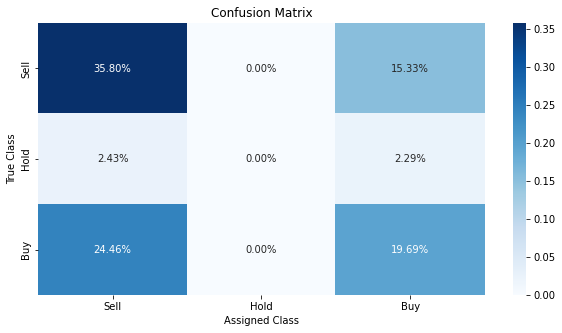

In [113]:
############## Feedforward NN with Two Hidden Layers ##############

#######################################
### Random Forest Feature Selection ###
#######################################
forest = RandomForestClassifier(random_state = 42)
select_rf = SelectFromModel(estimator = forest, threshold = "median")
select_rf.fit(X_train_std, y_train_cleaned)
X_train_std_rf = X_train_std[:, select_rf.get_support()]
X_test_std_rf = X_test_std[:, select_rf.get_support()]
print(X_train_std_rf.shape)
print(X_test_std_rf.shape)

input_size = X_train_std_rf.shape[1]
num_classes = 3
batch_size = 128
n_epochs =  100
hidden1 = 49
hidden2 = 49
dropout_rate = 0.2
dropout_rate2 = 0.15
model2 = FinMod2(input_size, hidden1, hidden2, num_classes, dropout_rate, dropout_rate2, F.leaky_relu, torch.tanh)
to_device(model2, device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 1e-4) 

evaluate_model(model2, kFold, X_train_std_rf, y_train_cleaned, X_test_std_rf, y_test_cleaned, batch_size, n_epochs, optimizer2)

(19653, 73)
(2179, 73)

------------------------------------- FOLD NUMBER: 1 -------------------------------------

Reset trainable parameters of layer = Linear(in_features=73, out_features=49, bias=True)
Reset trainable parameters of layer = Linear(in_features=49, out_features=49, bias=True)
Reset trainable parameters of layer = Linear(in_features=49, out_features=3, bias=True)
Epoch: 1/100  |   Training loss:  1.076221  |  Validation loss:  1.058637 | Validation weighted F1-Score:  0.451707  
Epoch: 2/100  |   Training loss:  1.043191  |  Validation loss:  1.026991 | Validation weighted F1-Score:  0.483187  
Epoch: 3/100  |   Training loss:  1.014454  |  Validation loss:  1.002137 | Validation weighted F1-Score:  0.380930  
Epoch: 4/100  |   Training loss:  0.995627  |  Validation loss:  0.988156 | Validation weighted F1-Score:  0.380144  
Epoch: 5/100  |   Training loss:  0.985514  |  Validation loss:  0.980885 | Validation weighted F1-Score:  0.396476  
Epoch: 6/100  |   Training l

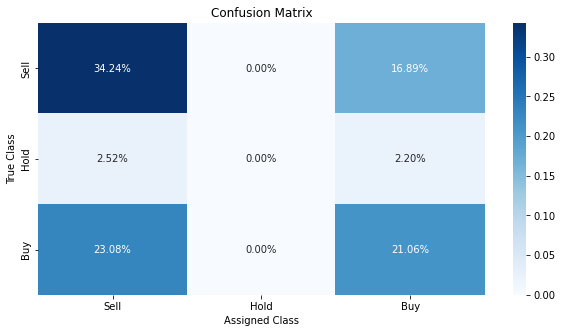

In [109]:
############## Feedforward NN with Two Hidden Layers ##############


#################################
### XGBoost Feature Selection ###
#################################
xgbc= xgb.XGBClassifier(tree_method = "gpu_hist", objective = "multi:softmax", random_state = 42)
select_xgbc = SelectFromModel(estimator = xgbc, threshold = "median")
select_xgbc.fit(X_train_std, y_train_cleaned)
X_train_std_xgbc = X_train_std[:, select_xgbc.get_support()]
X_test_std_xgbc = X_test_std[:, select_xgbc.get_support()]
print(X_train_std_xgbc.shape)
print(X_test_std_xgbc.shape)

input_size = X_train_std_xgbc.shape[1]
num_classes = 3
batch_size = 128
n_epochs =  100
hidden1 = 49
hidden2 = 49
dropout_rate = 0.2
dropout_rate2 = 0.15
model2 = FinMod2(input_size, hidden1, hidden2, num_classes, dropout_rate, dropout_rate2, F.leaky_relu, torch.tanh)
to_device(model2, device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 1e-4) 

evaluate_model(model2, kFold, X_train_std_xgbc, y_train_cleaned, X_test_std_xgbc, y_test_cleaned, batch_size, n_epochs, optimizer2)

We do not try out (Kernel) PCA since our Neural Network already automatically performs dimension reduction.

## Feature Engineering

We added our own variables (that are not a linear combination of other variables) to the dataset to see whether or not they improve our models. Instead of checking this for every single approach and model, we decided to just use the approach that yielded the highest weighted $F_1$-Score for the corresponding model. Important note:  <font color='red'> we have to remove our created expected_inflation feature because we realised that there was a **leakage** problem with it i.e. it yields a situation in which information is being used that should not be available at that time. For example, including the expected_inflation variable below raises the weighted $F_1-Score$ of our XGBoost model from 0.58 to 0.71. One can also replace the values of the expected_inflation with any five different distinct values e.g. just [2015, 2016, 2017, 2018, 2019] and get the same result. </font> We deduce that the reason for this problem is our approach of not treating the data as a time series when splitting our data into train-& test set. Because of our approach of mixing the different years in the train& test set, the expected_inflation can indicates which year a observation is from and due to the massive differences in the class proportions between years the models learns that e.g. in 2019 there were many buys even though this should not be known/ used to classify.

In [80]:
X_fe = findata.drop(["Class", "excess_return", "PRICE VAR [%]", "operating_liabilities", "NIC", "expected_inflation"], axis = 1) # drop response variable, variables that were used to calculate response and variables that are a linear combination of other variables
y_fe = findata["Class"] 
print(np.isinf(findata).values.sum()) # check whether some values are infinite since we sometimes divided by 0 for creating our own variables; KNN imputer cannot handle infinity

## Train-Test Split
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X_fe, y_fe, stratify = y_fe, test_size = 0.1, random_state = 42)

0


In [81]:
############## Imputation ##############
# First use X_train to fit the imputer, then apply it to X_train and X_test
# Important: We DO NOT use X_test to fit the imputer seperately
imputer = KNNImputer(n_neighbors = 5, weights = "distance")
X_train_fe = imputer.fit_transform(X_train_fe)
X_test_fe = imputer.transform(X_test_fe)
print("NAs remaining: ", sum(isnan(X_train_fe).flatten()))
print("NAs remaining: ", sum(isnan(X_test_fe).flatten()))

NAs remaining:  0
NAs remaining:  0


In [82]:
############## Outlier Detection ##############
## Isolation Forest
outliers = IsolationForest(random_state = 42).fit(X_train_fe) # fit Isolation Forest to training data
outliers_train = outliers.predict(X_train_fe)
outliers_test = outliers.predict(X_test_fe)

## Remove outliers where 1 represent inliers and -1 represent outliers:
X_train_fe_cleaned = X_train_fe[np.where(outliers_train == 1, True, False)]
y_train_fe_cleaned = y_train_fe[np.where(outliers_train == 1, True, False)]
X_test_fe_cleaned = X_test_fe[np.where(outliers_test == 1, True, False)]
y_test_fe_cleaned = y_test_fe[np.where(outliers_test == 1, True, False)]
print("Shape with outliers: ", X_train_fe.shape,", Shape without outliers: ", X_train_fe_cleaned.shape,", Removed outliers: ", X_train_fe.shape[0]-X_train_fe_cleaned.shape[0])
print("Shape with outliers: ", X_test_fe.shape,", Shape without outliers: ", X_test_fe_cleaned.shape,", Removed outliers: ", X_test_fe.shape[0]-X_test_fe_cleaned.shape[0]) 

Shape with outliers:  (19869, 147) , Shape without outliers:  (19633, 147) , Removed outliers:  236
Shape with outliers:  (2208, 147) , Shape without outliers:  (2179, 147) , Removed outliers:  29


 1 Gross Margin 0.0101
 2 priceToSalesRatio 0.0100
 3 cashPerShare 0.0100
 4 EBITDA Margin 0.0096
 5 EBIT Margin 0.0095
 6 Consolidated Income 0.0095
 7 Earnings Before Tax Margin 0.0095
 8 EBIT    0.0095
 9 EBITDA  0.0094
10 Weighted Average Shs Out 0.0094
11 Sector_Technology 0.0093
12 SG&A to Revenue 0.0092
13 Free Cash Flow margin 0.0092
14 Property, Plant & Equipment Net 0.0092
15 freeCashFlowPerShare 0.0087
16 Current ratio 0.0087
17 Net Profit Margin 0.0087
18 Cash and cash equivalents 0.0086
19 Cash and short-term investments 0.0086
20 priceToOperatingCashFlowsRatio 0.0085


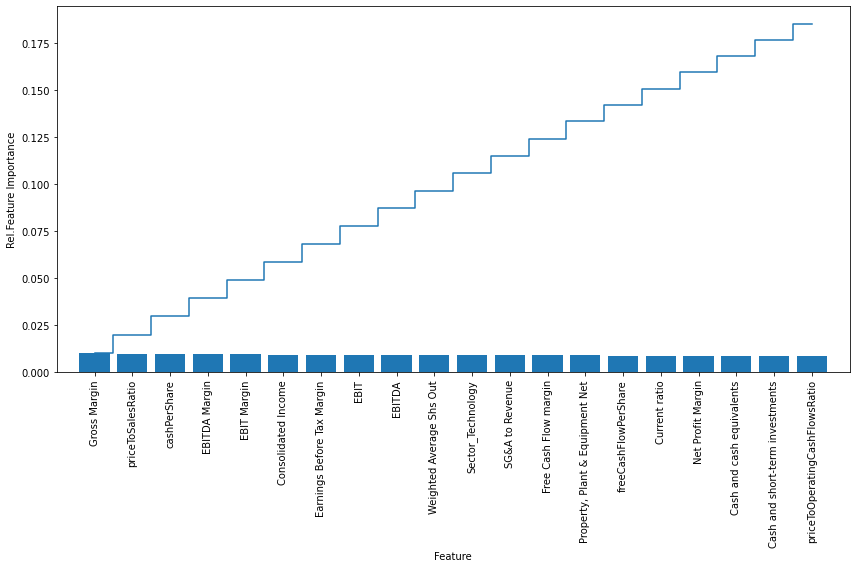

In [66]:
############## Feature Importance ##############
forest = RandomForestClassifier(random_state = 42)
plot_FI(forest, X_fe, 20, X_train_fe_cleaned, y_train_fe_cleaned)

 1 Earnings Yield 0.0261
 2 Tangible Asset Value 0.0257
 3 Book Value per Share 0.0243
 4 EPS Diluted Growth 0.0243
 5 dividendpaidAndCapexCoverageRatios 0.0240
 6 Shareholders Equity per Share 0.0179
 7 freeCashFlowPerShare 0.0179
 8 Operating Income 0.0165
 9 cashPerShare 0.0156
10 SG&A Expenses Growth 0.0152
11 SG&A to Revenue 0.0151
12 Total assets 0.0142
13 priceToSalesRatio 0.0130
14 Tangible Book Value per Share 0.0126
15 Earnings Before Tax Margin 0.0124
16 3Y Shareholders Equity Growth (per Share) 0.0118
17 3Y Revenue Growth (per Share) 0.0110
18 priceBookValueRatio 0.0110
19 priceFairValue 0.0101
20 Net Profit Margin 0.0100


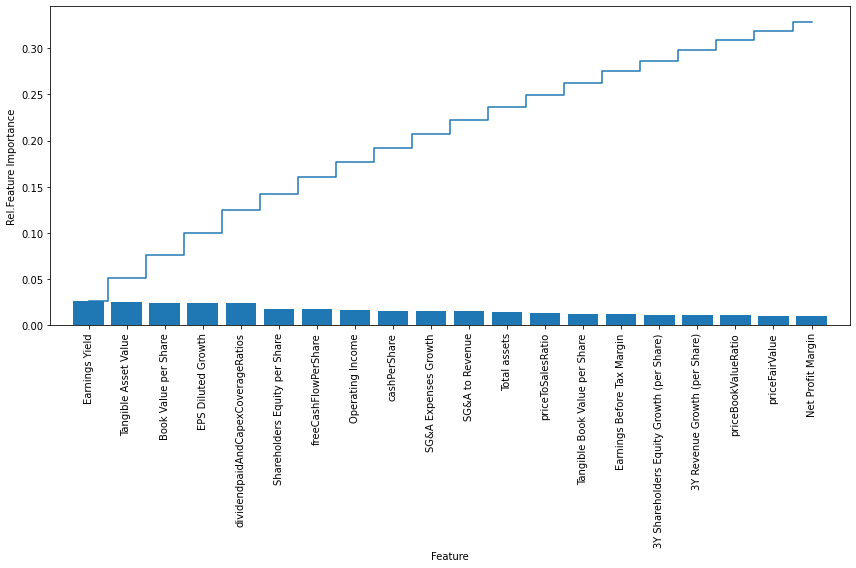

In [67]:
############## Feature Importance ##############
xgbc = xgb.XGBClassifier(tree_method = "gpu_hist", objective = "multi:softmax", random_state = 42)
plot_FI(xgbc, X_fe, 20, X_train_fe_cleaned, y_train_fe_cleaned)

We can see that the feature importance plots do not differ vastly from the ones without feature engineering.

### Logistic Regression

Best parameters: {'classifier__C': 6, 'classifier__penalty': 'l2', 'ros': None, 'scaler': StandardScaler()}
Mean CV score:  0.504935
Standard deviation of CV score:  0.011529
Test Score: 0.512658
              precision    recall  f1-score   support

           0       0.55      0.77      0.64      1113
           1       0.00      0.00      0.00       103
           2       0.53      0.35      0.42       963

    accuracy                           0.54      2179
   macro avg       0.36      0.37      0.35      2179
weighted avg       0.52      0.54      0.51      2179



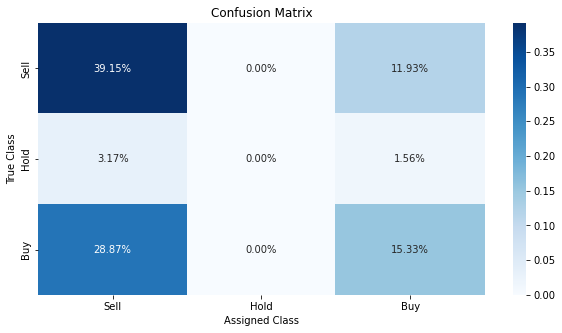

In [68]:
############## Logistic Regression ##############

####################
### All Features ###
####################
logistic = LogisticRegression(random_state=42, max_iter=20, n_jobs=-1) # initialize logistic regression classifier
# Set up pipeline
pipe = imbpipeline(steps=[["scaler", scaler], ["ros", ros], ["classifier", logistic]])
# Set up parameter grid with hyperparameters we want to tune
param_grid = {'ros': [ros, None], # upsampling or not
              'scaler': [scaler, None, mms], # scaling input by standardizing or min-max scaling or not scaling at all
              'classifier__C': [1, 6, 7, 8, 9, 10],
              'classifier__penalty': [None, 'l2', 'l1', 'elasticnet']}
# Conduct grid search with cross-validation to find hyperparameters that yield the best score
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
# Fit using the best parameters
gs = gs.fit(X_train_fe_cleaned, y_train_fe_cleaned)

# get results of cross-validation
get_results_cv(gs, X_test_fe_cleaned, y_test_fe_cleaned)
y_pred = gs.best_estimator_.predict(X_test_fe_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_fe_cleaned, y_pred)

### (Gaussian) Naive Bayes Classifier

Best parameters: {'kpca__n_components': 7, 'kpca__gamma': 0.006666666666666666, 'kpca__coef0': 0.8}
Mean CV score:  0.448365
Standard deviation of CV score:  0.016500
Test Score: 0.462871
              precision    recall  f1-score   support

           0       0.57      0.37      0.45      1114
           1       0.09      0.32      0.13       103
           2       0.49      0.54      0.51       962

    accuracy                           0.44      2179
   macro avg       0.38      0.41      0.37      2179
weighted avg       0.51      0.44      0.46      2179



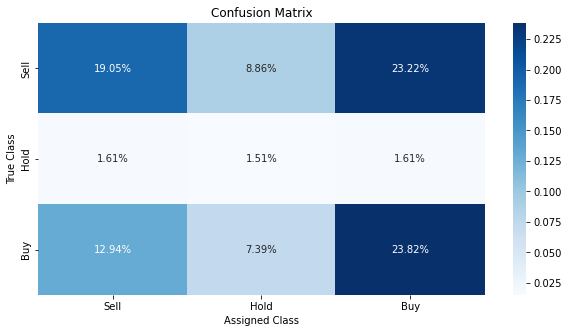

In [59]:
############## Naive Bayes ##############

##################
### Kernel PCA ###
##################

kpca_gnb = KernelPCA(random_state = 42, gamma = 0.0077777777777777776, coef0 = 0.8,
                        kernel = "sigmoid", eigen_solver = "arpack", n_jobs = -1)
gnb = GaussianNB(var_smoothing = 1.6681005372000556e-08)
pipe = imbpipeline(steps=[["scaler", scaler], ["kpca", kpca_gnb], ["ros", ros], ["gnb", gnb]])

random_grid = {
    "kpca__n_components": np.array([7, 10, 1]),
    "kpca__gamma": np.linspace(0.005, 0.01, 10),
    "kpca__coef0": np.linspace(0.8, 1.2, 10),
}

rs = RandomizedSearchCV(estimator = pipe, param_distributions = random_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1, n_iter = 30, random_state = 42, error_score = "raise")

rs = rs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(rs, X_test_cleaned, y_test_cleaned)
y_pred = rs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

### Random Forest

Best parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 5, 'rf__max_features': 'sqrt', 'rf__max_depth': 20, 'rf__criterion': 'gini', 'rf__class_weight': 'balanced_subsample'}
Mean CV score:  0.537303
Standard deviation of CV score:  0.003869
Test Score: 0.534065
              precision    recall  f1-score   support

           0       0.58      0.53      0.56      1114
           1       0.12      0.13      0.12       103
           2       0.53      0.58      0.55       962

    accuracy                           0.53      2179
   macro avg       0.41      0.41      0.41      2179
weighted avg       0.54      0.53      0.53      2179



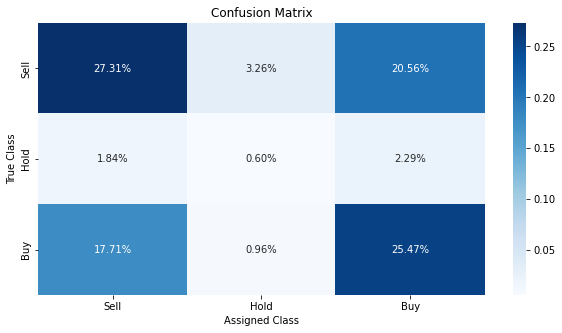

In [70]:
############## Random Forest ##############

####################
### All Features ###
####################
forest = RandomForestClassifier(random_state = 42)

rfpipe = imbpipeline(steps=[["ros", ros], ["rf", forest]]) # we saw that random forest performed better when not scaling the input

random_grid = {
    "rf__criterion": ["gini", "entropy"],
    "rf__max_features": ["auto", "sqrt", "log2"],
    "rf__max_depth": np.array([None, 5, 10, 20]),
    "rf__min_samples_leaf":np.array([1, 2, 5]),
    "rf__min_samples_split": np.array([2, 5, 10]),
    "rf__n_estimators": np.array([50, 100, 200]),
    "rf__class_weight": [None, "balanced", "balanced_subsample"]
}

rs = RandomizedSearchCV(estimator = rfpipe, param_distributions = random_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1, n_iter = 100, random_state = 42, error_score = "raise")
rs = rs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(rs, X_test_cleaned, y_test_cleaned)
y_pred = rs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'rf__max_depth': None, 'rf__n_estimators': 150}
Mean CV score:  0.538407
Standard deviation of CV score:  0.005216
Test Score: 0.535130
              precision    recall  f1-score   support

           0       0.58      0.55      0.57      1114
           1       0.11      0.12      0.12       103
           2       0.53      0.56      0.54       962

    accuracy                           0.53      2179
   macro avg       0.41      0.41      0.41      2179
weighted avg       0.54      0.53      0.54      2179



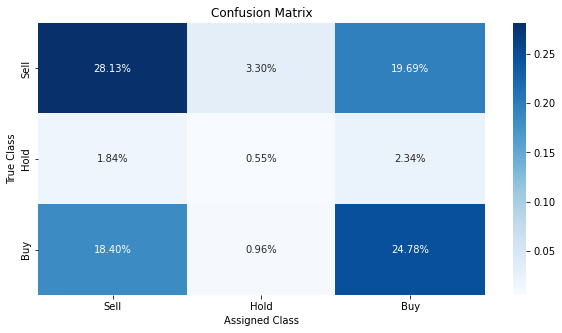

In [82]:
############## Random Forest ##############

################################
### All Features: Finetuning ###
################################
forest = RandomForestClassifier(random_state = 42, class_weight = "balanced_subsample", criterion = "gini", max_features = "sqrt", min_samples_split = 10, min_samples_leaf = 5)

rfpipe = imbpipeline(steps=[["ros", ros], ["rf", forest]])

param_grid = {
    "rf__max_depth": [None, 20],
    "rf__n_estimators": np.array([150, 200, 250])
}

gs = GridSearchCV(estimator = rfpipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

### Gradient Boosting

Best parameters: {'xgbc__gamma': 0, 'xgbc__learning_rate': 0.05, 'xgbc__max_depth': 5, 'xgbc__n_estimators': 200}
Mean CV score:  0.572865
Standard deviation of CV score:  0.007248
Test Score: 0.580934
              precision    recall  f1-score   support

           0       0.61      0.72      0.66      1114
           1       1.00      0.01      0.02       103
           2       0.59      0.52      0.55       962

    accuracy                           0.60      2179
   macro avg       0.73      0.42      0.41      2179
weighted avg       0.62      0.60      0.58      2179



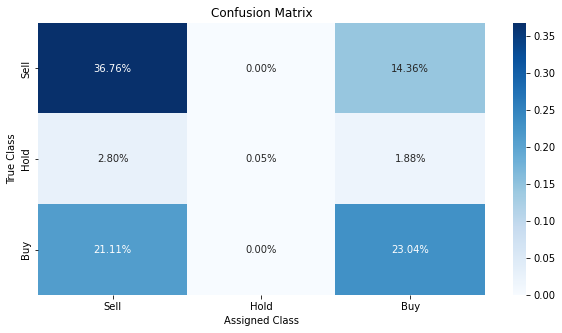

In [71]:
############## Gradient Boosting ##############

####################
### All Features ###
####################
xgbc= xgb.XGBClassifier(tree_method = "gpu_hist", objective = "multi:softmax", sampling_method = "gradient_based", random_state = 42)

xgbc_pipe = imbpipeline([
    ["xgbc", xgbc] # we saw that xgboost performed best without upsampling or scaling the data
])


param_grid = {
    "xgbc__max_depth": [3, 4, 5, 6],
    "xgbc__n_estimators": [100, 200, 500],
    "xgbc__learning_rate": [0.001, 0.01, 0.05],
    "xgbc__gamma": [0, 0.25, 0.5, 0.75, 1],
}
gs = GridSearchCV(estimator = xgbc_pipe, param_grid = param_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

Best parameters: {'xgbc__learning_rate': 0.05, 'xgbc__n_estimators': 175}
Mean CV score:  0.574296
Standard deviation of CV score:  0.007401
Test Score: 0.580706
              precision    recall  f1-score   support

           0       0.60      0.72      0.66      1114
           1       1.00      0.01      0.02       103
           2       0.59      0.52      0.55       962

    accuracy                           0.60      2179
   macro avg       0.73      0.42      0.41      2179
weighted avg       0.62      0.60      0.58      2179



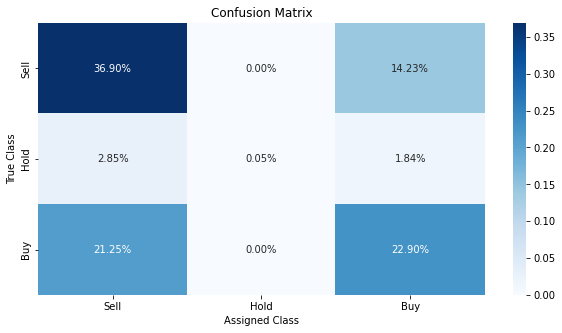

In [80]:
############## Gradient Boosting ##############

################################
### All Features: Finetuning ###
################################
xgbc= xgb.XGBClassifier(tree_method = "gpu_hist", objective = "multi:softmax", 
                        sampling_method = "gradient_based", random_state = 42, max_depth = 5, learning_rate = 0.05, gamma = 0)

xgbc_pipe = imbpipeline([
    ["xgbc", xgbc]
])

param_grid = {
    "xgbc__n_estimators": [175, 200, 225],
    "xgbc__learning_rate": [0.03, 0.05, 0.07]
}
gs = GridSearchCV(estimator = xgbc_pipe, param_grid = param_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_cleaned, y_train_cleaned)

get_results_cv(gs, X_test_cleaned, y_test_cleaned)
y_pred = gs.best_estimator_.predict(X_test_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

### Support Vector Machine

Parameters of the Support Vector Machine: dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])
Best parameters: {'SVM__C': 1, 'SVM__gamma': 'scale', 'SVM__kernel': 'sigmoid', 'ros': None, 'scaler': MinMaxScaler()}
Mean CV score:  0.453515
Standard deviation of CV score:  0.042505
Test Score: 0.492818
              precision    recall  f1-score   support

           0       0.54      0.65      0.59      1113
           1       0.00      0.00      0.00       103
           2       0.47      0.41      0.44       963

    accuracy                           0.51      2179
   macro avg       0.33      0.35      0.34      2179
weighted avg       0.48      0.51      0.49      2179



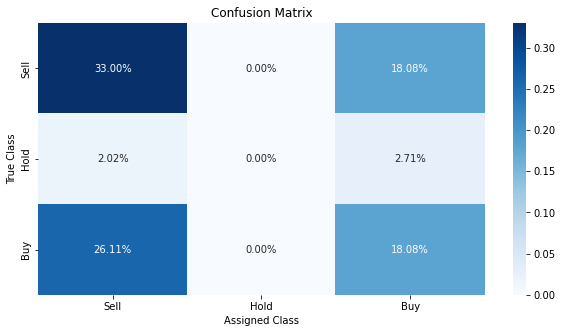

In [84]:
############## Support Vector Machine ##############

####################
### All Features ###
####################
svm = SVC(random_state = 42, max_iter = 1000, shrinking = True)
print(f"Parameters of the Support Vector Machine: {svm.get_params().keys()}")

svm_pipe = imbpipeline(steps=[["scaler", scaler], ["ros", ros], ["SVM", svm]])
param_grid = {
    'ros': [ros, None], 
    'scaler': [scaler, mms],
    "SVM__kernel": ["linear", "sigmoid"],
    "SVM__C": [1, 10],
    "SVM__gamma": ["auto", "scale"]
}
gs = GridSearchCV(estimator = svm_pipe, param_grid = param_grid, scoring = "f1_weighted",
                  cv = kFold, n_jobs = -1)
gs = gs.fit(X_train_fe_cleaned, y_train_fe_cleaned)

get_results_cv(gs, X_test_fe_cleaned, y_test_fe_cleaned)
y_pred = gs.best_estimator_.predict(X_test_fe_cleaned)
# get test score, metrics report and confusion matrix
final_report(y_test_fe_cleaned, y_pred)

### Neural Network


------------------------------------- FOLD NUMBER: 1 -------------------------------------

Reset trainable parameters of layer = Linear(in_features=147, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=3, bias=True)
Epoch: 1/100  |   Training loss:  1.063387  |  Validation loss:  1.030295 | Validation weighted F1-Score:  0.389932  
Epoch: 2/100  |   Training loss:  1.007724  |  Validation loss:  0.990245 | Validation weighted F1-Score:  0.373531  
Epoch: 3/100  |   Training loss:  0.984684  |  Validation loss:  0.979159 | Validation weighted F1-Score:  0.431566  
Epoch: 4/100  |   Training loss:  0.977024  |  Validation loss:  0.974419 | Validation weighted F1-Score:  0.452054  
Epoch: 5/100  |   Training loss:  0.972764  |  Validation loss:  0.971483 | Validation weighted F1-Score:  0.476770  
Epoch: 6/100  |   Training loss:  0.969949  | 

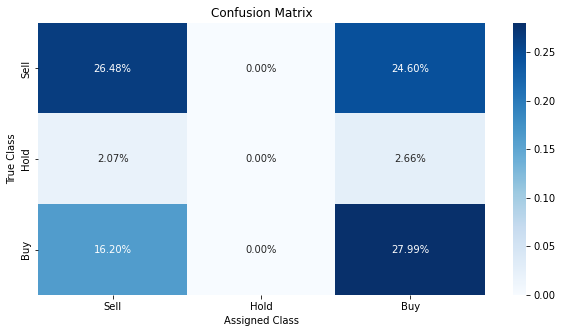

In [115]:
############## Feedforward NN with Two Hidden Layers ##############

####################
### All Features ###
####################
X_train_fe_std = sc.fit_transform(X_train_fe_cleaned)
X_test_fe_std = sc.fit_transform(X_test_fe_cleaned)

input_size = X_train_fe_std.shape[1]
num_classes = 3
batch_size = 128
n_epochs =  100
hidden1 = 100
hidden2 = 100
dropout_rate = 0.2
dropout_rate2 = 0.15
model2 = FinMod2(input_size, hidden1, hidden2, num_classes, dropout_rate, dropout_rate2, F.leaky_relu, torch.tanh)
to_device(model2, device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 1e-4) 

evaluate_model(model2, kFold, X_train_fe_std, y_train_fe_cleaned, X_test_fe_std, y_test_fe_cleaned, batch_size, n_epochs, optimizer2)

## Appendix

In [ ]:
!pip install -U skorch
from skorch import NeuralNetClassifier

     |████████████████████████████████| 155 kB 4.3 MB/s 


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9068       0.5165        0.8615  0.4127
      2        0.8661       0.5254        0.8488  0.4212
      3        0.8550       0.5234        0.8440  0.4391
      4        0.8482       0.5323        0.8414  0.4083
      5        0.8472       0.5310        0.8401  0.4012
      6        0.8449       0.5351        0.8395  0.4045
      7        0.8426       0.5344        0.8390  0.4153
      8        0.8422       0.5338        0.8385  0.4061
      9        0.8399       0.5346        0.8382  0.4104
     10        0.8389       0.5300        0.8383  0.4038
Best parameters: {'net__lr': 0.01, 'net__module__activ_func': <function tanh at 0x7f7ea22b0440>, 'net__module__dropout_rate': 0.15, 'net__module__hidden_size': 100, 'ros': None, 'scaler': None}
Mean CV score:  0.523159
Standard deviation of CV score:  0.007787
Test Score: 0.510899
              precision    recall 

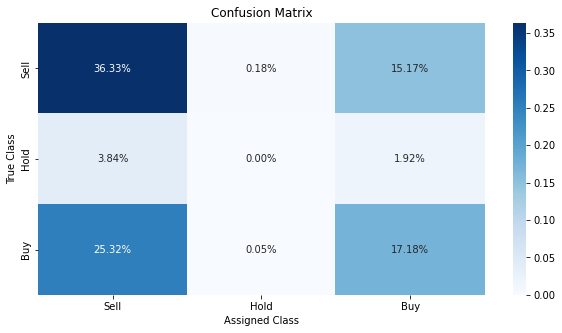

In [ ]:
############## Skorch: Feedforward Neural Network with 1 Hidden Layer ##############
# Create Neural Network Classifier
net = NeuralNetClassifier(
    module=FinMod1,
    max_epochs = 10,
    lr = 0.01,
    module__input_size = 145,
    module__output_size = 3,
    module__hidden_size=100,
    module__dropout_rate=0.2,
    module__activ_func=F.relu,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.SGD,
    device = "cuda"
)
# Create pipeline
pipe = imbpipeline(steps=[["scaler", scaler],
                          ["ros", ros], ["net", net]])
# Create parameter grid for hyperparametertuning
param_grid= {
    "scaler": [scaler, mms, None],
    "ros": [ros, None],
    "net__module__hidden_size": [90, 100, 110],
    "net__module__dropout_rate": [0.15, 0.2, 0.25],
    "net__module__activ_func": [F.relu, F.leaky_relu, F.tanh],
    "net__lr": [0.001, 0.01]
}
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
# Convert train set to type accepted by skorch
X_train_cleaned_f, y_train_cleaned_i = X_train_cleaned.astype(np.float32), y_train_cleaned.astype(np.int64)
gs = gs.fit(X_train_cleaned_f, y_train_cleaned_i)

# Convert test set to type accepted by skorch
X_test_cleaned_f, y_test_cleaned_i = X_test_cleaned.astype(np.float32), y_test_cleaned.astype(np.int64)
get_results_cv(gs, X_test_cleaned_f, y_test_cleaned_i)
y_pred = gs.best_estimator_.predict(X_test_cleaned_f)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9115       0.5165        0.8575  0.4177
      2        0.8666       0.5242        0.8487  0.4398
      3        0.8570       0.5277        0.8453  0.4155
      4        0.8512       0.5247        0.8433  0.4199
      5        0.8514       0.5275        0.8418  0.4126
      6        0.8500       0.5270        0.8406  0.4253
      7        0.8476       0.5285        0.8398  0.4343
      8        0.8461       0.5277        0.8392  0.4453
      9        0.8446       0.5293        0.8388  0.4151
     10        0.8442       0.5303        0.8383  0.4191
Best parameters: {'net__module__activ_func1': <function tanh at 0x7fcd3c3784d0>, 'net__module__activ_func2': <function tanh at 0x7fcd3c3784d0>, 'net__module__dropout_rate1': 0.2, 'net__module__dropout_rate2': 0.2, 'net__module__hidden1_size': 100, 'net__module__hidden2_size': 20, 'ros': None, 'scaler': None}
Mean C

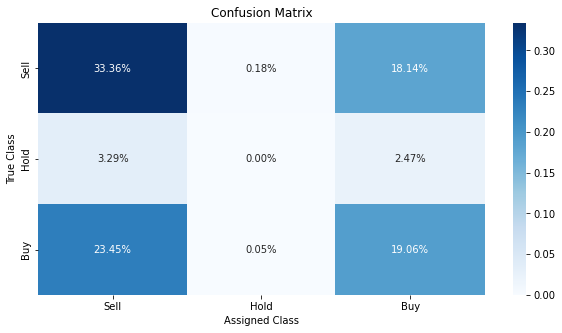

In [ ]:
############## Skorch: Feedforward Neural Network with 2 Hidden Layers ##############
net = NeuralNetClassifier(
    module=FinMod2,
    max_epochs = 10,
    lr = 0.01,
    module__input_size = 145,
    module__output_size = 3,
    module__hidden1_size= 100,
    module__hidden2_size = 30,
    module__dropout_rate1 =0.2,
    module__dropout_rate2 = 0.2,
    module__activ_func1 = F.relu,
    module__activ_func2 = F.relu, 
    criterion=torch.nn.NLLLoss,
    device = "cuda"
)

pipe = imbpipeline(steps=[["scaler", scaler],
                          ["ros", ros], ["net", net]])

param_grid= {
    "scaler": [scaler, mms, None],
    "ros": [ros, None],
    "net__module__hidden1_size": [80, 100],
    "net__module__hidden2_size": [10, 20],
    "net__module__dropout_rate1": [0.2, 0.4],
    "net__module__dropout_rate2": [0.2, 0.4],
    "net__module__activ_func1": [F.relu, F.leaky_relu, F.tanh],
    "net__module__activ_func2": [F.relu, F.leaky_relu, F.tanh],

}
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, scoring = "f1_weighted", cv = kFold, n_jobs = -1)
X_train_cleaned_f, y_train_cleaned_i = X_train_cleaned.astype(np.float32), y_train_cleaned.astype(np.int64)
gs = gs.fit(X_train_cleaned_f, y_train_cleaned_i)

X_test_cleaned_f, y_test_cleaned_i = X_test_cleaned.astype(np.float32), y_test_cleaned.astype(np.int64)
get_results_cv(gs, X_test_cleaned_f, y_test_cleaned_i)
y_pred = gs.best_estimator_.predict(X_test_cleaned_f)
# get test score, metrics report and confusion matrix
final_report(y_test_cleaned, y_pred)